# Well-log based reservoir property estimation with machine learning

* __Author__: _Lei Fu, Chicheng Xu, Yanxiang Yu, Michael Ashby, Andy McDonald, and Bin Bai_
* __Date__: November 1st, 2021

- <a>1. Introduction </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Discussion</a>
- <a>9. Summary</a>

<a></a>

## Abstract

Well-log data play a key role in estimating reservoir properties, including volumes of minerals, porosity, and water saturation that are critical for reserve estimation. A conventional workflow using a multimineral physical model based on core-log integration requires an a priori rock-fluid model; therefore, it is often inadequate in reservoirs of complex minerals such as carbonate or unconventional fields. There is a potential for applying machine learning (ML) for data-driven solutions. In this tutorial, we demonstrated a machine-learning approach to predict reservoir properties based on conventional well logs. This tutorial aims to provide a starting point for the participants of the 2021 Machine Learning Contest organized by the Society of
Petrophysicists and Well Log Analysts (SPWLA) Petrophysical Data-Driven Analytics Special Interest Group (PDDA-SIG). It applied the Random Forest (RF) regression method to simultaneously predict shale volume, porosity, and water saturation based on conventional well logs (gamma ray, bulk density, neutron porosity, resistivity, and sonic). The RF algorithm was tested with a data set from the Equinor Volve Field. A total of 35,046 data points collected from eight wells were used to train and validate the model. The trained model was then applied on the hidden testing data set from four wells in the same field and achieved reasonable accuracy. The solutions from different participants will be ranked based on the averaged root-mean-squared-error (RMSE) score measured on the blind-testing data set.

## <a>1. Introduction</a>

### <a>1.1. Background</a>
Well logs are interpreted and processed to estimate in-situ reservoir properties (including petrophysical, geomechanical, and geochemical properties), which is essential for reservoir modeling, reserve estimation, and production forecasting. The modeling is often based on multimineral physics or empirical formulae. When sufficient training data are available, a machine-learning solution provides an alternative approach to estimate those reservoir properties based on well-log data and usually has less turnaround time and human involvement.

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop data-driven models to estimate reservoir properties, including shale volume, porosity, and fluid saturation, based on a common set of well logs, including gamma ray, bulk density, neutron porosity, resistivity, and sonic. The participants will be provided with log data from eight wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. They need to build a data-driven model using the provided training data set. Following that, they will deploy the newly developed data-driven models on the test data set to predict the reservoir properties based on
the well-log data.

You will be provided with log data from about 10 wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. You need to build a data-driven model using the provided training dataset. Following that, you will deploy the newly developed data-driven models on the test dataset to predict the reservoir properties based on the well log data. 

### <a>1.3. Data Description</a>
#### Files
&gt; #### train.csv
(All the values equals to -9999 are marked as missing values.)
- WELLNUM - Well number
- DEPTH - Depth, unit in feet
- DTC - Compressional Travel-time, unit in nanosecond per foot
- DTS - Shear Travel-time, unit in microseconds per foot
- BS - Bit size, unit in inch
- CAL - Caliper, unit in Inc
- DEN - Density, unit in Gram per cubic centimeter 
- DENC - Corrected density, unit in Gram per cubic centimeter 
- GR - Gamma Ray, unit in API
- NEU - Neutron, unit in dec
- PEF - Photo-electric Factor, unit in barns/e
- RDEP - Deep Resistivity, unit in Ohm.m
- RMED - Medium Resistivity, unit in Ohm.m
- ROP - Rate of penetration, unit in meters per hour
- PHIF - Porosity, a unit equals to the percentage of pore space in a unit volume of rock.
- SW - Water saturation
- VSH - Shale Volume

&gt; #### test.csv
The test data has all features that you used in the train dataset, except PHIF, SW, and VSH.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated according to root mean squared error(RMSE)

$$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{\mathbf{y_{i}}} - \mathbf{y_{i}})^{2}} = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{1, i} - y_{1, i})^{2}+(\hat{y}_{2, i} - y_{2, i})^{2}+(\hat{y}_{3, i} - y_{3, i})^{2}}$$

where
- $\hat{y_i}$ is the predicted values of the true values $y_i$. Both $\hat{y_i}$ and $y_i$ are vectors with 3 elements: $y_{1,i}$ - PHIF, $y_{2,i}$ - SW, and $y_{3,i}$ - VSH. 
- $m$ is sample size.

**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible. 
- PHIF, SW, and VSH are in the same weight during the evaluation. 
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.

## <a>2. Imports</a>

In [132]:
# https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model

# https://yougome.tistory.com/495

# https://heung-bae-lee.github.io/2020/05/27/machine_learning_15/

In [133]:
"""
F12 and input below sentence to console
function ClickConnect() {var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); buttons.forEach(function(btn) { btn.click(); }); console.log("auto reconnect every 10 min"); document.querySelector("colab-toolbar-button#connect").click(); } setInterval(ClickConnect,1000*600);
"""

'\nF12 and input below sentence to console\nfunction ClickConnect() {var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); buttons.forEach(function(btn) { btn.click(); }); console.log("auto reconnect every 10 min"); document.querySelector("colab-toolbar-button#connect").click(); } setInterval(ClickConnect,1000*600);\n'

In [134]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from matplotlib import pyplot
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import Lasso
from sklearn import neighbors
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
#from sklearn import cross_validation
from sklearn.neural_network import MLPRegressor

import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import missingno as msno
import pandas as pd
import random as rnd
from xgboost import XGBClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import lightgbm as lgb
from scipy import stats
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, accuracy_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import keras
from keras.layers import Input, Flatten, MaxPool2D, Dropout
#from keras.optimizers import RMSprop, Adam, Adadelta
from scipy.stats import randint, uniform
#from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')
filename1 = '/content/drive/My Drive/train.csv'
filename2 = '/content/drive/My Drive/test.csv'
filename3 = '/content/drive/My Drive/new_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <a>3. Read Data</a>

In [136]:
df3 = pd.read_csv(filename1)
type(df3)

pandas.core.frame.DataFrame

In [137]:
df_new_test = pd.read_csv(filename3)
type(df_new_test)

pandas.core.frame.DataFrame

## <a>4. Glimps Data</a>

In [138]:
# # df_new_test.drop(['CALI', 'BS', 'DEPTH', 'RMED', 'WELLNUM'], axis = 1, inplace = True)
# # df_new_test.drop(['CALI', 'BS', 'DEPTH', 'WELLNUM'], axis = 1, inplace = True)
# df_new_test['CMED'] = 1 / df_new_test['RMED']**0.5
# df_new_test['CDEP'] = 1 / df_new_test['RDEP']**0.5
# df_new_test = df_new_test[['DEN',	'NEU',	'GR',	'CDEP',	'CMED']]

# # df3['VW'] = df3['PHIF']*df3['SW']

# df_new_test.describe()


In [139]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# df3.drop(['DTC'], axis = 1, inplace = True)
# df3.drop(['DTS'], axis = 1, inplace = True)
# df3.drop(['DEPTH', 'BS', 'CALI'], axis = 1, inplace = True)

# df3.describe()

In [140]:
df3.head()

WELLNUM     DEPTH          DTC  ...         PHIF           SW          VSH
0        0 335.16010 -9,999.00000  ... -9,999.00000 -9,999.00000 -9,999.00000
1        0 335.66010 -9,999.00000  ... -9,999.00000 -9,999.00000 -9,999.00000
2        0 336.16010 -9,999.00000  ... -9,999.00000 -9,999.00000 -9,999.00000
3        0 336.66010 -9,999.00000  ... -9,999.00000 -9,999.00000 -9,999.00000
4        0 337.16010 -9,999.00000  ... -9,999.00000 -9,999.00000 -9,999.00000

[5 rows x 17 columns]

In [141]:
df_new_test.head()

WELLNUM        DEPTH      BS    CALI  ...     PEF    RDEP    RMED       ROP
0      100 15,912.50000 8.50000 8.27566  ... 5.85873 2.88135 2.64501 262.28170
1      100 15,913.00000 8.50000 8.27566  ... 6.02133 2.88135 2.64501 262.03700
2      100 15,913.50000 8.50000 8.27566  ... 6.06028 3.02738 2.92899 261.98810
3      100 15,914.00000 8.50000 8.27566  ... 6.20241 3.05465 2.97495 261.71960
4      100 15,914.50000 8.50000 8.28682  ... 5.17970 3.05465 2.97495 261.52470

[5 rows x 12 columns]

## <a>5. Exploratory Data Analysis</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

### Feature Selection
In this tutorial, five commonly used logs (DEN, GR, NEU, PEF, RDEP) are selected together with target columns (PHIF, SW, VSH).

NOTE: 
> Here, we dropped the data point, if any column in (DEN, GR, NEU, PEF, RDEP, PHIF, SW, VSH) contains missing values. As a result, only about $12\%$ of data is left. 

### Handling the Missing Data
"-9999" is shown as the missing value in all features. To handle the missing values, we first replace all the values equal to "-9999" to `np.nan` and then remove all the rows that contain the `nan` by using `dropna()` function. This is another quick implementation provided in the Pandas library.

In [142]:
df3.describe()

WELLNUM         DEPTH  ...            SW           VSH
count 318,967.00000 318,967.00000  ... 318,967.00000 318,967.00000
mean        4.08101   6,998.18000  ...  -8,515.69341  -8,585.15849
std         2.46280   3,797.93686  ...   3,554.21772   3,484.03887
min         0.00000     335.16010  ...  -9,999.00000  -9,999.00000
25%         2.00000   3,757.87400  ...  -9,999.00000  -9,999.00000
50%         4.00000   6,905.18400  ...  -9,999.00000  -9,999.00000
75%         6.00000  10,052.49000  ...  -9,999.00000  -9,999.00000
max         8.00000  15,651.58000  ...       1.00000       3.65430

[8 rows x 17 columns]

In [143]:
# For this tutorial, we only use five measurements (DEN, GR, NEU, PEF, RDEP) as input, 
# you should determine which measurements to include in your model. 
col_names =  ['DEN', 'GR', 'NEU', 'RDEP', 'RMED'] + list(df3.columns.values[-3:])
initial_names = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED']
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'PEF'] #PHIF RMSE: 0.00756 VSH RMSE: 0.02580 VW RMSE: 0.04880 total_RMSE: 0.0321646205697067
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'PEF', 'CALI', 'DENC', 'ROP'] # PHIF RMSE: 0.00684 VSH RMSE: 0.02268 SW RMSE: 0.05807 VW RMSE: 0.04492 total_RMSE: 0.02932267828773778
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP', 'WATER'] # PHIF RMSE: 0.00615 VSH RMSE: 0.01367 SW RMSE: 0.05807 VW RMSE: 0.04350 total_RMSE: 0.026562945523111656
input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP', 'WATER'] 
# PHIF RMSE: 0.00654 VSH RMSE: 0.02187 SW RMSE: 0.02150 total_RMSE:  0.06080225135863956 # with WATER on all targets
# PHIF RMSE: 0.00971 VSH RMSE: 0.02243 SW RMSE: 0.02150 total_RMSE:  0.01879470577510986 # without WATER on PHIF and VSH

# input_names = ['DEN', 'NEU', 'GRn', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP', 'WATER'] # PHIF RMSE: 0.00520 VSH RMSE: 0.01236 SW RMSE: 0.04129 VW RMSE: 0.13345 total_RMSE:  0.0774379768055979
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'PEF'] # PHIF RMSE: 0.00738 VSH RMSE: 0.02671 SW RMSE: 0.05807 VW RMSE: 0.05523 total_RMSE: 0.03567528957563449
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'PEF'] # PHIF RMSE: 0.00738 VSH RMSE: 0.02671 SW RMSE: 0.05807 VW RMSE: 0.05523 total_RMSE: 0.03567528957563449
# input_names = ['DEN', 'NEU', 'GR', 'CDEP', 'PEF'] # PHIF RMSE: 0.00749 VSH RMSE: 0.02657 SW RMSE: 0.05807 VW RMSE: 0.05463 total_RMSE:  0.035340569039098775
# input_names = ['DEN', 'NEU', 'GR', 'RDEP', 'PEF'] # PHIF RMSE: 0.00749 VSH RMSE: 0.02657 SW RMSE: 0.05807 VW RMSE: 0.05463 total_RMSE:  0.035340569039098775

# DEN, NEU, GR, RDEP
# input_names1 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP'] # PHIF RMSE: 0.00923
# input_names1 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'PEF'] # PHIF RMSE: 0.01029
# input_names1 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP'] # PHIF RMSE: 0.01122
input_names1 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'PEF'] # PHIF RMSE: 0.01052
# input_names1 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'PEF', 'SHALE', 'OIL'] # PHIF RMSE: 0.01006

# GR, NEU, DEN, RDEP
# input_names2 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP'] # VSH RMSE: 0.01292
# input_names2 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'PEF'] # VSH RMSE: 0.02705
input_names2 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'PEF'] # VSH RMSE: 0.02277
# input_names2 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'PEF'] # VSH RMSE: 0.02705
# input_names2 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'PEF', 'SHALE', 'OIL'] # VSH RMSE: 0.02537

# RDEP, WATER, DEN, NEU, CDEP
# input_names3 = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED', 'CDEP', 'CMED', 'DEPTH', 'PEF', 'CALI', 'DENC', 'ROP', 'WATER'] # SW RMSE: 0.02227
# input_names3 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'WATER'] # SW RMSE: 0.03909
input_names3 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'WATER'] # SW RMSE: 0.03741
# input_names3 = ['DEN', 'NEU', 'GR', 'RDEP', 'CDEP', 'WATER', 'SHALE', 'OIL'] # SW RMSE: 0.03243

input_names_old = ['DEN', 'NEU', 'GR', 'RDEP', 'RMED']

# Replace -9999 with np.nan
df3.replace(['-9999', -9999], np.nan, inplace=True)

# remove all rows that contains missing value 
df3.dropna(axis=0, subset=col_names, inplace=True)
df3.describe()

WELLNUM        DEPTH  ...           SW          VSH
count 42,072.00000 42,072.00000  ... 42,072.00000 42,072.00000
mean       4.98110 12,240.95331  ...      0.66905      0.27574
std        2.27342  1,606.34389  ...      0.35441      0.20702
min        0.00000  8,494.00000  ...      0.01300     -0.24800
25%        4.00000 11,187.66000  ...      0.30000      0.11320
50%        6.00000 11,903.54000  ...      0.81340      0.23300
75%        6.00000 13,349.49250  ...      1.00000      0.36062
max        8.00000 15,566.93000  ...      1.00000      2.46010

[8 rows x 17 columns]

In [144]:
# Checking Test data distributions
df_new_test_100 = df_new_test[df_new_test['WELLNUM']==100]
df_new_test_101 = df_new_test[df_new_test['WELLNUM']==101]
df_new_test_103 = df_new_test[df_new_test['WELLNUM']==103]
df_new_test_104 = df_new_test[df_new_test['WELLNUM']==104]
print('size of df_new_test is ', df_new_test.shape)
print('size of df_new_test_100 is ', df_new_test_100.shape)
print('size of df_new_test_102 is ', df_new_test_101.shape)
print('size of df_new_test_103 is ', df_new_test_103.shape)
print('size of df_new_test_104 is ', df_new_test_104.shape)

size of df_new_test is  (11275, 12)
size of df_new_test_100 is  (3063, 12)
size of df_new_test_102 is  (2646, 12)
size of df_new_test_103 is  (2235, 12)
size of df_new_test_104 is  (3331, 12)


In [145]:
# Checking Train data distributions
df3_0 = df3[df3['WELLNUM']==0]
df3_1 = df3[df3['WELLNUM']==1]
df3_2 = df3[df3['WELLNUM']==2]
df3_3 = df3[df3['WELLNUM']==3]
df3_4 = df3[df3['WELLNUM']==4]
df3_5 = df3[df3['WELLNUM']==5]
df3_6 = df3[df3['WELLNUM']==6]
df3_7 = df3[df3['WELLNUM']==7]
df3_8 = df3[df3['WELLNUM']==8]
print('size of df3 is ', df3.shape)
print('size of df3_0 is ', df3_0.shape)
print('size of df3_1 is ', df3_1.shape)
print('size of df3_2 is ', df3_2.shape)
print('size of df3_3 is ', df3_3.shape)
print('size of df3_4 is ', df3_4.shape)
print('size of df3_5 is ', df3_5.shape)
print('size of df3_6 is ', df3_6.shape)
print('size of df3_7 is ', df3_7.shape)
print('size of df3_8 is ', df3_8.shape)

size of df3 is  (42072, 17)
size of df3_0 is  (1880, 17)
size of df3_1 is  (2872, 17)
size of df3_2 is  (2281, 17)
size of df3_3 is  (2105, 17)
size of df3_4 is  (8399, 17)
size of df3_5 is  (1533, 17)
size of df3_6 is  (13722, 17)
size of df3_7 is  (2017, 17)
size of df3_8 is  (7263, 17)


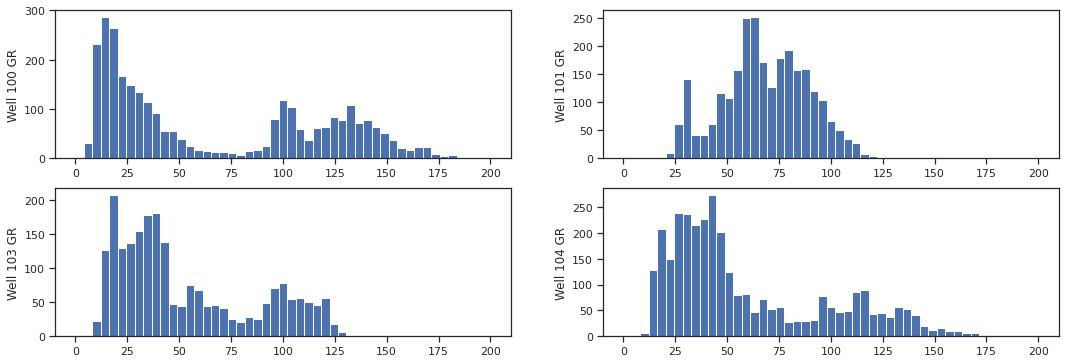

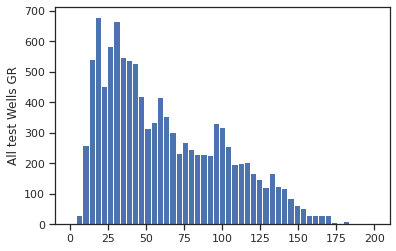

In [146]:
bins = np.linspace(0, 200, 50)

plt.figure(figsize=(18, 6))
plt.subplot(221)
plt.hist(df_new_test_100['GR'], bins)
plt.ylabel('Well 100 GR')
plt.subplot(222)
plt.hist(df_new_test_101['GR'], bins)
plt.ylabel('Well 101 GR')
plt.subplot(223)
plt.hist(df_new_test_103['GR'], bins)
plt.ylabel('Well 103 GR')
plt.subplot(224)
plt.hist(df_new_test_104['GR'], bins)
plt.ylabel('Well 104 GR')
plt.show()

plt.hist(df_new_test['GR'], bins)
plt.ylabel('All test Wells GR')
plt.show()


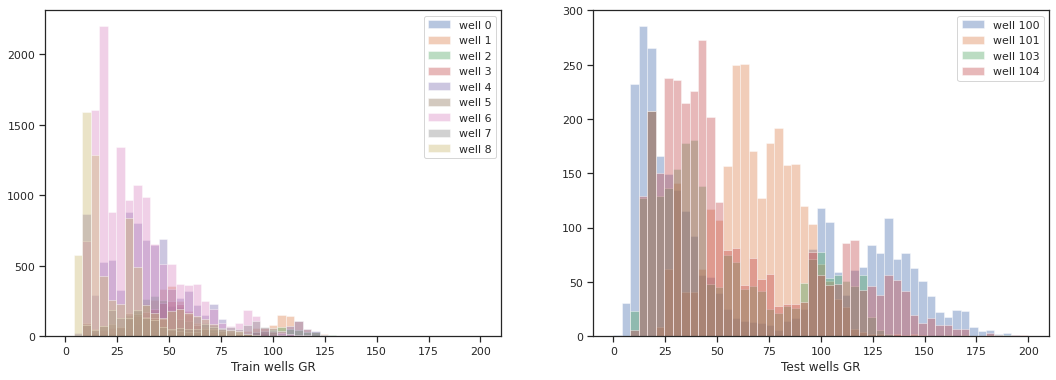

5% quantile of df3['GR'] :  10.2768575
95% quantile of df3['GR'] :  91.29615
5% quantile of df_new_test['GR'] :  14.536705999999999
95% quantile of df_new_test['GR'] :  140.11078


In [147]:

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.hist(df3_0['GR'], bins, alpha=0.4, label='well 0')
plt.hist(df3_1['GR'], bins, alpha=0.4, label='well 1')
plt.hist(df3_2['GR'], bins, alpha=0.4, label='well 2')
plt.hist(df3_3['GR'], bins, alpha=0.4, label='well 3')
plt.hist(df3_4['GR'], bins, alpha=0.4, label='well 4')
plt.hist(df3_5['GR'], bins, alpha=0.4, label='well 5')
plt.hist(df3_6['GR'], bins, alpha=0.4, label='well 6')
plt.hist(df3_7['GR'], bins, alpha=0.4, label='well 7')
plt.hist(df3_8['GR'], bins, alpha=0.4, label='well 8')
plt.legend(loc='upper right')
plt.xlabel('Train wells GR')
plt.subplot(122)
plt.hist(df_new_test_100['GR'], bins, alpha=0.4, label='well 100')
plt.hist(df_new_test_101['GR'], bins, alpha=0.4, label='well 101')
plt.hist(df_new_test_103['GR'], bins, alpha=0.4, label='well 103')
plt.hist(df_new_test_104['GR'], bins, alpha=0.4, label='well 104')
plt.legend(loc='upper right')
plt.xlabel('Test wells GR')
plt.show()

quant = 0.05
Q1_train_GR = np.quantile(df3['GR'], quant)
Q5_train_GR = np.quantile(df3['GR'], 1-quant)
Q1_test_GR = np.quantile(df_new_test['GR'], quant)
Q5_test_GR = np.quantile(df_new_test['GR'], 1-quant)
print("5% quantile of df3['GR'] : ", Q1_train_GR)
print("95% quantile of df3['GR'] : ", Q5_train_GR)
print("5% quantile of df_new_test['GR'] : ", Q1_test_GR)
print("95% quantile of df_new_test['GR'] : ", Q5_test_GR)

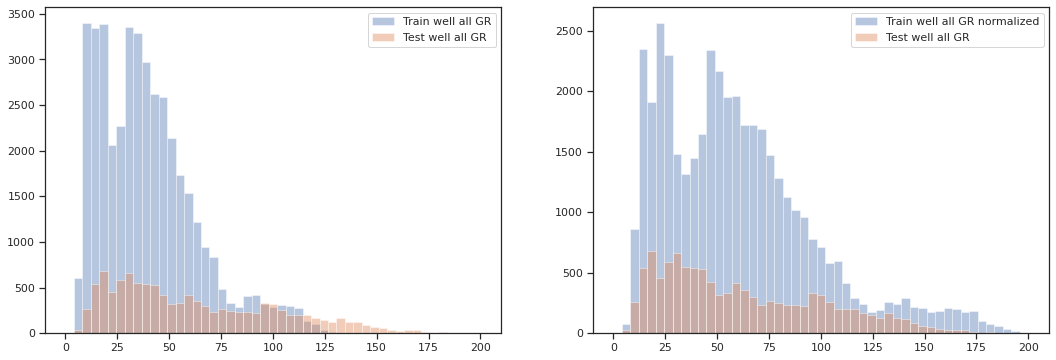

In [148]:
# GR Normalization using test data as a reference
df3['GRn'] = (df3['GR']-Q1_train_GR)/(Q5_train_GR-Q1_train_GR)*(Q5_test_GR-Q1_test_GR)+Q1_test_GR
df3['VSHn'] = (df3['VSH']-Q1_train_GR)/(Q5_train_GR-Q1_train_GR)*(Q5_test_GR-Q1_test_GR)+Q1_test_GR
df_new_test['GRn'] = df_new_test['GR'].copy()

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.hist(df3['GR'], bins, alpha=0.4, label='Train well all GR')
plt.hist(df_new_test['GR'], bins, alpha=0.4, label='Test well all GR')
plt.legend(loc='upper right')
plt.subplot(122)
plt.hist(df3['GRn'], bins, alpha=0.4, label='Train well all GR normalized')
plt.hist(df_new_test['GR'], bins, alpha=0.4, label='Test well all GR')
plt.legend(loc='upper right')

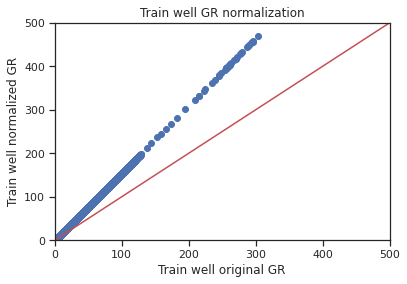

In [149]:
plt.scatter(df3['GR'], df3['GRn'])
plt.plot([0,500], [0,500], 'r')
plt.xlabel('Train well original GR')
plt.ylabel('Train well normalized GR')
plt.axis([0,500,0,500])
plt.title('Train well GR normalization');
plt.show()


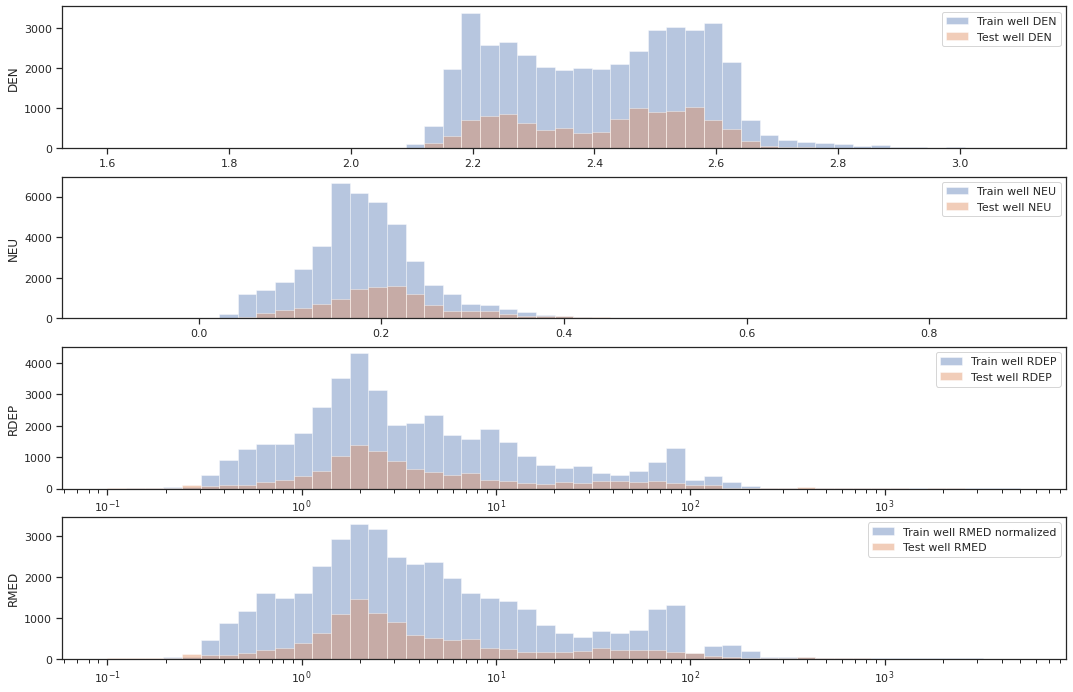

In [150]:
# Check other feature Normalization using test data as a reference
# df3['GRn'] = (df3['GR']-Q1_train_GR)/(Q5_train_GR-Q1_train_GR)*(Q5_test_GR-Q1_test_GR)+Q1_test_GR
bins_DEN = np.linspace(1.6, 3.1, 50)
bins_NEU = np.linspace(-0.1, 0.9, 50)
# bins_RDEP = np.logspace(0.1, 5000, 50)
# bins_RMED = np.logspace(0.1, 5000, 50)
bins_RDEP = np.logspace(np.log10(0.1), np.log10(5000), 50)
bins_RMED = np.logspace(np.log10(0.1), np.log10(5000), 50)

plt.figure(figsize=(18, 12))
plt.subplot(411)
plt.hist(df3['DEN'], bins_DEN, alpha=0.4, label='Train well DEN')
plt.hist(df_new_test['DEN'], bins_DEN, alpha=0.4, label='Test well DEN')
plt.ylabel('DEN')
plt.legend(loc='upper right')
plt.subplot(412)
plt.hist(df3['NEU'], bins_NEU, alpha=0.4, label='Train well NEU')
plt.hist(df_new_test['NEU'], bins_NEU, alpha=0.4, label='Test well NEU')
plt.ylabel('NEU')
plt.legend(loc='upper right')
plt.subplot(413)
plt.hist(df3['RDEP'], bins_RDEP, alpha=0.4, label='Train well RDEP')
plt.hist(df_new_test['RDEP'], bins_RDEP, alpha=0.4, label='Test well RDEP')
plt.ylabel('RDEP')
plt.legend(loc='upper right')
plt.xscale('log')
plt.subplot(414)
plt.hist(df3['RMED'], bins_RMED, alpha=0.4, label='Train well RMED normalized')
plt.hist(df_new_test['RMED'], bins_RMED, alpha=0.4, label='Test well RMED')
plt.ylabel('RMED')
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()


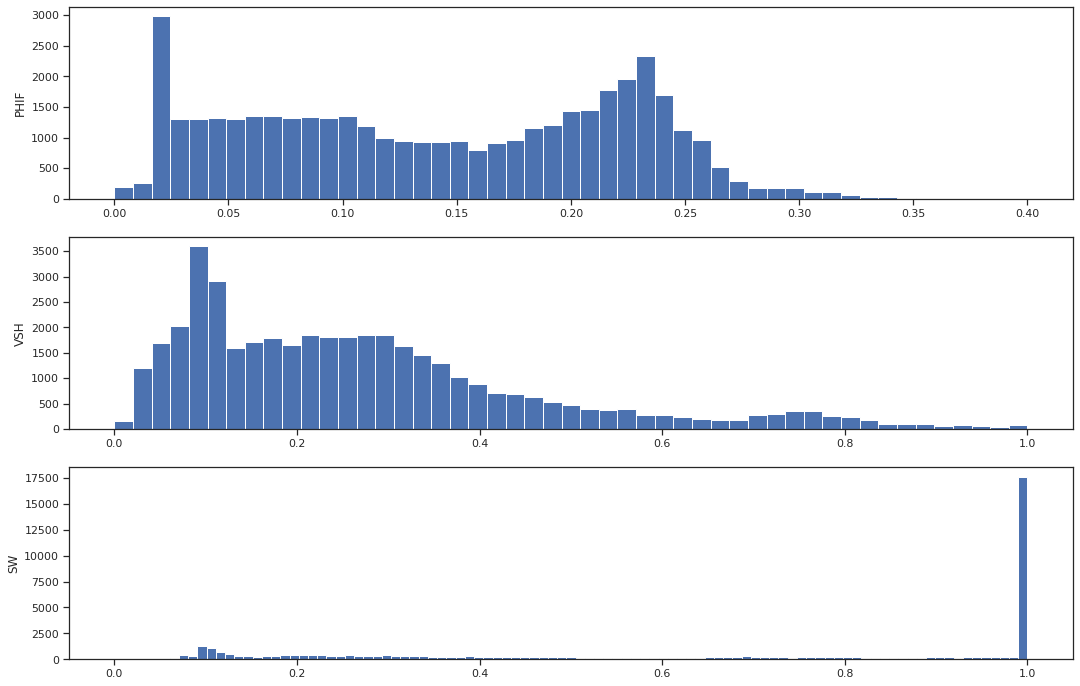

In [151]:
# Check other feature Normalization using test data as a reference
bins_PHIF = np.linspace(0, 0.4, 50)
bins_VSH = np.linspace(0, 1, 50)
bins_SW = np.linspace(0, 1, 100)

plt.figure(figsize=(18, 12))
plt.subplot(311)
plt.hist(df3['PHIF'], bins_PHIF)
plt.ylabel('PHIF')
plt.subplot(312)
plt.hist(df3['VSH'], bins_VSH)
plt.ylabel('VSH')
plt.subplot(313)
plt.hist(df3['SW'], bins_SW)
plt.ylabel('SW')
plt.show()


In [152]:
df3['SW'].value_counts()
df3[df3['SW']==1].value_counts() 

WELLNUM  DEPTH         DTC       DTS        BS       CALI     DEN      DENC     GR         NEU      PEF      RDEP     RMED     ROP       PHIF     SW       VSH      GRn        VSHn    
7        14,806.43000  81.28550  146.93420  8.50000  8.77080  2.54110  0.07750  88.39530   0.17880  7.22590  1.68720  1.90490  14.95890  0.06200  1.00000  0.83600  135.61467  -0.09594    1
2        11,913.39000  75.45560  135.22030  8.50000  8.67190  2.61860  0.05690  113.53400  0.20100  0.05690  2.48180  2.50060  15.84160  0.02000  1.00000  0.82960  174.57785  -0.10586    1
         11,923.23000  72.39090  127.76510  8.50000  8.68750  2.60990  0.05960  70.57280   0.09730  0.05960  3.13880  3.16800  15.92980  0.02290  1.00000  0.48870  107.99108  -0.63423    1
         11,922.90000  72.83500  128.71510  8.50000  8.67190  2.60900  0.05850  91.32760   0.11630  0.05850  3.08290  3.09990  15.91810  0.02340  1.00000  0.65340  140.15953  -0.37896    1
         11,922.57000  73.09190  129.33920  8.50000  8.67190

In [153]:
# # Remove anomlay
# clf3 = IsolationForest(random_state=0).fit_predict(df3[col_names3])
# df3 = df3[clf3==1]
# del [[clf3]]
# gc.collect()
# df3.describe()

### Removing the Outliers
You may find that the maximum values of all features are dramatically larger than their mean values, which indicates anomalies and outliers exist in the data set. It's helpful to remove those abnormal data points to improve the performance of the model trained. Here, we used the Isolation Forest algorithm to remove the outliers. We suggest that the contestants try their best to quality control the log data. More information on this can be found in Misra et al. (2019).

### Correlation

The below function is used to quickly check if there's any correlation between features and targets. It is suggested to conduct this practice for all the features and gain more insights.

In [154]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
# plt.scatter(df3['GR'], df3['VSH'])
# plt.xlabel('GR')
# plt.ylabel('VSH')

## <a>6. Build Machine Learning Models</a>

### Identifying the Features and Targets
We will use the first five data columns as the input features for the desired machine-learning task and the last three columns as the targets. We extract the feature vectors and the associated target vectors from the training and testing data set as:

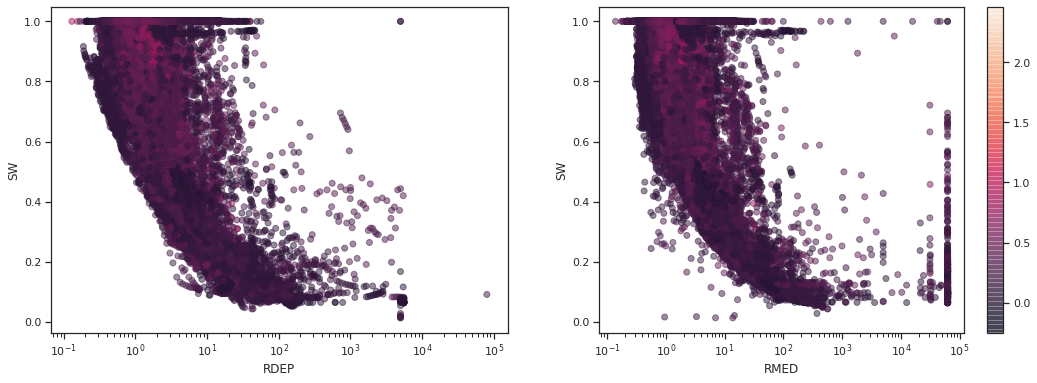

In [155]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
well = df3[df3['RDEP']>0.01]

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.scatter(well['RDEP'], well['SW'], alpha=0.5, c=well['VSH'])
pyplot.xscale('log')
plt.xlabel('RDEP')
plt.ylabel('SW')
plt.subplot(122)
plt.scatter(well['RMED'], well['SW'], alpha=0.5, c=well['VSH'])
pyplot.xscale('log')
plt.xlabel('RMED')
plt.ylabel('SW')
plt.colorbar()

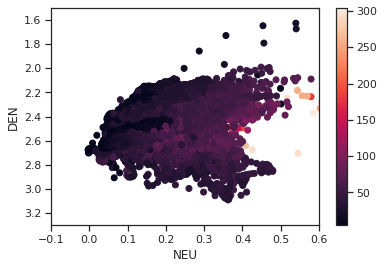

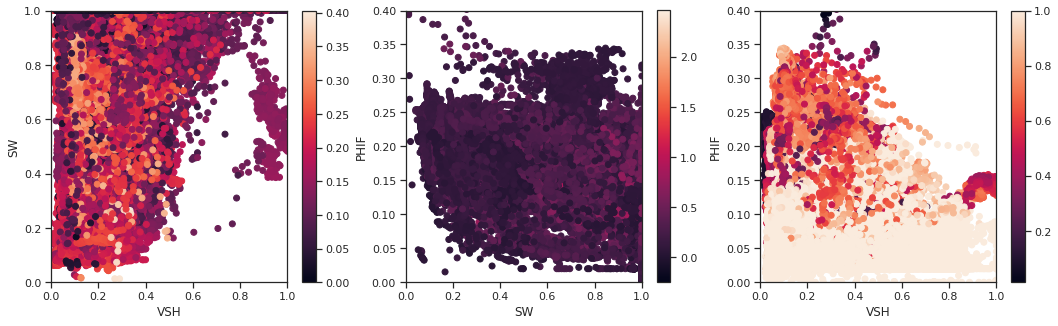

In [156]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
well = df3[df3['SW'] > 0.01]
plt.figure(figsize=(6,4))
plt.scatter(well['NEU'], well['DEN'], c=well['GR'])
plt.axis([-0.1, 0.6, 1.5, 3.3])
plt.gca().invert_yaxis()
plt.xlabel('NEU')
plt.ylabel('DEN')
plt.colorbar()
plt.show()

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(well['VSH'], well['SW'], c=well['PHIF'])
plt.axis([0, 1, 0, 1])
plt.xlabel('VSH')
plt.ylabel('SW')
plt.colorbar()
plt.subplot(132)
plt.scatter(well['SW'], well['PHIF'], c=well['VSH'])
plt.axis([0, 1, 0, 0.4])
plt.xlabel('SW')
plt.ylabel('PHIF')
plt.colorbar()
plt.subplot(133)
plt.scatter(well['VSH'], well['PHIF'], c=well['SW'])
plt.axis([0, 1, 0, 0.4])
plt.xlabel('VSH')
plt.ylabel('PHIF')
plt.colorbar()
plt.show()

In [157]:
# Create conductivities from resistivities
df3.loc[df3['RMED'] > 5000, 'RMED'] = 5000
df3.loc[df3['RDEP'] > 5000, 'RDEP'] = 5000
df_new_test.loc[df_new_test['RMED'] > 5000, 'RMED'] = 5000
df_new_test.loc[df_new_test['RDEP'] > 5000, 'RDEP'] = 5000
df_new_test['CMED'] = 1 / df_new_test['RMED']**0.5
df_new_test['CDEP'] = 1 / df_new_test['RDEP']**0.5
df3.loc[df3['PHIF'] <0.005, 'PHIF'] = 0.005
df3['CMED'] = 1 / df3['RMED']**0.5
df3['CDEP'] = 1 / df3['RDEP']**0.5
# VSH correction
df3.loc[df3['VSH'] < 0.005, 'VSH'] = 0.005
df3.loc[df3['VSH'] > 1, 'VSH'] = 1

# Create volume of water
df3['VW'] = df3['PHIF']*df3['SW']
# Create water resistivity from Archie's law
df3['RW'] = df3['RDEP'] * df3['PHIF']**2 * df3['SW']**2
df3.loc[df3['RW'] > 0.05, 'RW'] = 0.05
df3.loc[df3['RW'] < 0.0005, 'RW'] = 0.0005

# Create various flags targets
df3['WATER'] = (df3['SW']>0.95) & (df3['PHIF']>0.01)
df3['SAND'] = (df3['PHIF']>0.16) & (df3['VSH']<0.6)
df3['OIL'] = (df3['VSH']<0.6) & (df3['SW']>0.55)
df3['SHALE'] = (df3['VSH']>0.8) & (df3['SW']<0.8)
df3['WATER'].astype(int)
df3['SAND'].astype(int)
df3['OIL'].astype(int)
df3['SHALE'].astype(int)

df3.describe()

WELLNUM        DEPTH  ...           VW           RW
count 42,072.00000 42,072.00000  ... 42,072.00000 42,072.00000
mean       4.98110 12,240.95331  ...      0.07400      0.01811
std        2.27342  1,606.34389  ...      0.05140      0.01138
min        0.00000  8,494.00000  ...      0.00256      0.00050
25%        4.00000 11,187.66000  ...      0.03225      0.01003
50%        6.00000 11,903.54000  ...      0.06217      0.01744
75%        6.00000 13,349.49250  ...      0.09818      0.02375
max        8.00000 15,566.93000  ...      0.31982      0.05000

[8 rows x 23 columns]

In [158]:
# df3.dropna(axis=0, subset=col_names, inplace=True)
df3[col_names].isna().sum()


DEN     0
GR      0
NEU     0
RDEP    0
RMED    0
PHIF    0
SW      0
VSH     0
dtype: int64

In [159]:
# Random forest model for WATER zone identification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(df3[initial_names], df3['WATER'], test_size = 0.33, random_state = 100)
rfc_100w = RandomForestClassifier(n_estimators=300, random_state=100)

# fit the model to the training set
rfc_100w.fit(X_water_train, y_water_train)

# Predict on the test set results
y_pred_100s = rfc_100w.predict(X_water_test)
y_test_water = rfc_100w.predict(df_new_test[initial_names])

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_water_test, y_pred_100s)))
df_new_test['WATER'] = y_test_water
df_new_test['WATER'] = df_new_test['WATER'].astype(int)
df_new_test['WATER'].value_counts()


Model accuracy score with 100 decision-trees : 0.9695


0    6077
1    5198
Name: WATER, dtype: int64

In [160]:
# Random forest model for SAND zone identification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_sand_train, X_sand_test, y_sand_train, y_sand_test = train_test_split(df3[initial_names], df3['SAND'], test_size = 0.33, random_state = 100)
rfc_100s = RandomForestClassifier(n_estimators=300, random_state=100)

# fit the model to the training set
rfc_100s.fit(X_sand_train, y_sand_train)

# Predict on the test set results
y_pred_100s = rfc_100s.predict(X_sand_test)
y_test_sand = rfc_100s.predict(df_new_test[initial_names])

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_water_test, y_pred_100s)))
df_new_test['SAND'] = y_test_sand
df_new_test['SAND'] = df_new_test['SAND'].astype(int)
df_new_test['SAND'].value_counts()



Model accuracy score with 100 decision-trees : 0.1842


0    7196
1    4079
Name: SAND, dtype: int64

In [161]:
# # hyperparameter tunning for random forest classification (this takes too much time)
# n_estimators = [int(x) for x in range(200,2200,400)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(df3[initial_names], df3['SAND'])
# rf_random.best_params_

In [162]:
# Random forest model for OIL zone identification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_OIL_train, X_OIL_test, y_OIL_train, y_OIL_test = train_test_split(df3[initial_names], df3['OIL'], test_size = 0.33, random_state = 100)
rfc_100o = RandomForestClassifier(n_estimators=300, random_state=100)

# fit the model to the training set
rfc_100o.fit(X_OIL_train, y_OIL_train)

# Predict on the test set results
y_pred_100o = rfc_100o.predict(X_OIL_test)
y_test_OIL = rfc_100o.predict(df_new_test[initial_names])

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_OIL_test, y_pred_100o)))
df_new_test['OIL'] = y_test_OIL
df_new_test['OIL'] = df_new_test['OIL'].astype(int)

Model accuracy score with 100 decision-trees : 0.9829


In [163]:
# Random forest model for SHALE zone identification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_SHALE_train, X_SHALE_test, y_SHALE_train, y_SHALE_test = train_test_split(df3[initial_names], df3['SHALE'], test_size = 0.33, random_state = 100)
rfc_100sh = RandomForestClassifier(n_estimators=300, random_state=100)

# fit the model to the training set
rfc_100sh.fit(X_SHALE_train, y_SHALE_train)

# Predict on the test set results
y_pred_100sh = rfc_100sh.predict(X_SHALE_test)
y_test_SHALE = rfc_100sh.predict(df_new_test[initial_names])

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_SHALE_test, y_pred_100sh)))
df_new_test['SHALE'] = y_test_SHALE
df_new_test['SHALE'] = df_new_test['SHALE'].astype(int)

Model accuracy score with 100 decision-trees : 0.9996


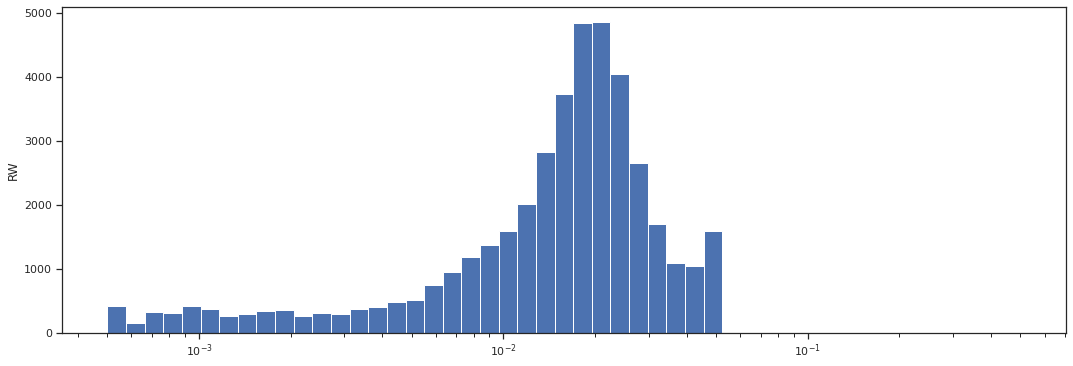

mean of Rw is  0.01810531807597821


In [164]:
bins_RW = np.logspace(np.log10(0.0005), np.log10(0.5), 50)
plt.figure(figsize=(18, 6))
plt.hist(df3['RW'], bins_RW)
plt.ylabel('RW')
plt.xscale('log')
plt.show()
print("mean of Rw is ", df3['RW'].mean())

In [165]:
df3.describe()

WELLNUM        DEPTH  ...           VW           RW
count 42,072.00000 42,072.00000  ... 42,072.00000 42,072.00000
mean       4.98110 12,240.95331  ...      0.07400      0.01811
std        2.27342  1,606.34389  ...      0.05140      0.01138
min        0.00000  8,494.00000  ...      0.00256      0.00050
25%        4.00000 11,187.66000  ...      0.03225      0.01003
50%        6.00000 11,903.54000  ...      0.06217      0.01744
75%        6.00000 13,349.49250  ...      0.09818      0.02375
max        8.00000 15,566.93000  ...      0.31982      0.05000

[8 rows x 23 columns]

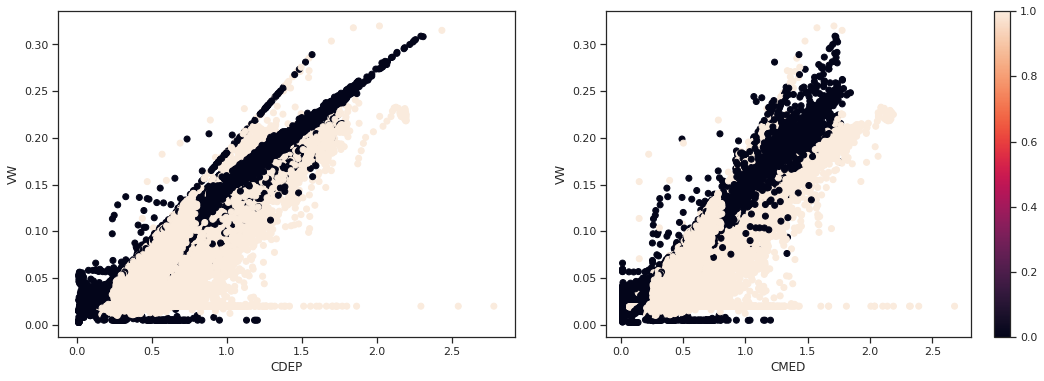

In [166]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
well = df3[df3['VW']>0.001]

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.scatter(well['CDEP'], well['VW'], alpha=1, c=well['WATER'])
# plt.scatter(well['CDEP'], well['VW'], alpha=0.2)
plt.xlabel('CDEP')
plt.ylabel('VW')
plt.subplot(122)
plt.scatter(well['CMED'], well['VW'], alpha=1, c=well['WATER'])
# plt.scatter(well['CMED'], well['VW'], alpha=0.2)
plt.xlabel('CMED')
plt.ylabel('VW')
plt.colorbar()

# well in 4 and 6

In [167]:
df3.describe()

WELLNUM        DEPTH  ...           VW           RW
count 42,072.00000 42,072.00000  ... 42,072.00000 42,072.00000
mean       4.98110 12,240.95331  ...      0.07400      0.01811
std        2.27342  1,606.34389  ...      0.05140      0.01138
min        0.00000  8,494.00000  ...      0.00256      0.00050
25%        4.00000 11,187.66000  ...      0.03225      0.01003
50%        6.00000 11,903.54000  ...      0.06217      0.01744
75%        6.00000 13,349.49250  ...      0.09818      0.02375
max        8.00000 15,566.93000  ...      0.31982      0.05000

[8 rows x 23 columns]

In [168]:
# Inputs and Targets selections
# Preparing Targets
Y_for_phif = df3['PHIF']
Y_for_vsh = df3['VSH']
# Y_for_vsh = df3['VSHn']
Y_for_sw = df3['SW']
Y_for_vw = df3['VW']

# Preparing Input features
X_for_phif = df3[input_names1]
X_for_vsh = df3[input_names2]
X_for_sw = df3[input_names3]
X_for_vw = df3[input_names3] # estimated phif to be add in later section

X_for_submission = df_new_test[input_names]
X_for_submission1 = df_new_test[input_names1]
X_for_submission2 = df_new_test[input_names2]
X_for_submission3 = df_new_test[input_names3]


### Splitting the Data Set Into Training and Testing Data Sets

A standard practice before doing any further data preprocessing and training the supervised learning model is to separate the data into the training and testing data sets, where the testing set can be used to evaluate the generalization of the model in terms of overfitting or underfitting. Once the train-test split is performed, the test data set should not be touched to avoid information leakage from the testing data set to the training data set. The testing data set should be used only for purposes of evaluating the generalization capability of the model. In the code shown below, we used the first seven wells for training and the last well for validation purposes. The participants may apply different strategies to separate the training data set and testing set.

### Training
After training on the X_train and y_train, the Random Forest regression model was then evaluated on the training data set. 

In [169]:

# model_score = pd.DataFrame(columns=['MODEL', 'RMSE', 'PHIF', 'SW', 'VSH', 'TRAIN SCORE', 'VAL SCORE'])
# model_score.style.set_precision(5)
# PHIF_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_PHIF', 'TRAIN SCORE', 'VAL SCORE'])
# PHIF_model_score.style.set_precision(5)
# SW_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_SW', 'TRAIN SCORE', 'VAL SCORE'])
# SW_model_score.style.set_precision(5)
# VSH_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_VSH', 'TRAIN SCORE', 'VAL SCORE'])
# VSH_model_score.style.set_precision(5)
pd.set_option('display.float_format', '{:,.5f}'.format)

!pip3 install catboost
!pip install xgboost
!pip install lightgbm
# !pip install pyspark
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
#!tar xf spark-2.4.1-bin-hadoop2.7.tgz
#!pip install -q findspark
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
# from sklearn.cross_decomposition import HuberRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import GammaRegressor
from sklearn.svm import NuSVR
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
# from pyspark.ml.regression import GeneralizedLinearRegression, GBTRegressor
# from pyspark.ml.linalg import Vectors
from sklearn.linear_model import OrthogonalMatchingPursuitCV
# import org.apache.spark.ml.regression.GeneralizedLinearRegression
from sklearn.svm import LinearSVR
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

In [170]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=100)

In [171]:
!pip install --quiet optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [172]:
def objectiveXGB(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 20, 4000),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.3), 
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 1),
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'gamma' : trial.suggest_int('gamma', 0, 5), 
        'subsample' : trial.suggest_float('subsample', 0.1, 1.0), 
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0), 
        'max_depth' : trial.suggest_int('max_depth', 1, 30), 
        'max_features' : trial.suggest_float('max_features', 0.3, 1.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        # 'random_state' : trial.suggest_categorical('random_state', [100])
    }
    model = XGBRegressor(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10, verbose=False)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [173]:
# vsh
# Best trial param: {'n_estimators': 328, 'learning_rate': 0.02, 'alpha': 0.004050988264847441, 'lambda': 0.5391777174568733, 'gamma': 0, 'subsample': 0.5421609605209023, 'colsample_bytree': 0.7586668875791515, 'max_depth': 2, 'max_features': 0.6, 'min_child_weight': 255, 'random_state': 100}
# Best trial RMSE: 0.03672146198768465


In [174]:
# sw
# Best trial param: {'n_estimators': 399, 'learning_rate': 0.02, 'alpha': 0.023903833029769107, 'lambda': 0.008247008050909478, 'gamma': 0, 'subsample': 0.5252225641487763, 'colsample_bytree': 0.7723592321738842, 'max_depth': 2, 'max_features': 0.9, 'min_child_weight': 112, 'random_state': 100}
# Best trial RMSE: 0.07458332641619236

In [175]:
# study = optuna.create_study(sampler=TPESampler(seed=100), direction="minimize")
# study.optimize(lambda trial : objectiveXGB(trial, X_train_full_sw, y_train_full_sw), n_trials=30, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)
# Best trial param: {'n_estimators': 1196, 'learning_rate': 0.05, 'alpha': 0.011714093302114275, 'lambda': 0.006458758955253696, 'gamma': 0, 'subsample': 0.6477981389608624, 'colsample_bytree': 0.6067816445514742, 'max_depth': 1, 'max_features': 0, 'min_child_weight': 50, 'random_state': 100}
# Best trial RMSE: 0.012142357606377704

In [176]:
# optuna.visualization.plot_param_importances(study)

In [177]:
# optuna.visualization.plot_optimization_history(study)

In [178]:
def objectiveGBR(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.045, 0.05, 0.055, 0.06, 0.065, 0.07]), 
        'alpha' : trial.suggest_float('alpha', 0, 1),
        'subsample' : trial.suggest_float('subsample', 0.4, 0.9), 
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 5), 
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 5), 
        'max_depth' : trial.suggest_int('max_depth', 1, 6), 
        'max_features' : trial.suggest_categorical('max_features', ['auto']),
        'random_state' : trial.suggest_categorical('random_state', [100])
    }
                                       
    model = GradientBoostingRegressor(**param)
    #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [179]:
# study = optuna.create_study(sampler=TPESampler(seed=100), direction="minimize")
# study.optimize(lambda trial : objectiveGBR(trial, X_train_for_vsh, y_train_for_vsh), n_trials=30, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [180]:
# optuna.visualization.plot_param_importances(study)

In [181]:
# optuna.visualization.plot_optimization_history(study)

In [182]:
def objectiveRFR(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'random_state' : trial.suggest_categorical('random_state', [100]),
        'criterion' : trial.suggest_categorical('criterion', ['squared_error']),
        'max_depth' : trial.suggest_int('max_depth', 1, 30),
        'max_features' : trial.suggest_categorical('max_features', ['auto']),
    }
                                       
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [183]:
# study = optuna.create_study(sampler=TPESampler(seed=42), direction="minimize")
# study.optimize(lambda trial : objectiveRFR(trial, X_train_for_phif, y_train_for_phif), n_trials=10, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [184]:
# optuna.visualization.plot_param_importances(study)

In [185]:
# optuna.visualization.plot_optimization_history(study)

In [186]:
def objectiveLGB(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = {
        'min_child_weight' : trial.suggest_categorical('min_child_weight', [0.001, 0.002, 0.003, 0.009, 0.008, 0.007, 0.006, 0.005]),
        'random_state' : trial.suggest_categorical('random_state', [100]),
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree', 0.1, 1),         
        'objective': 'regression',
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',2, 20),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.02, 0.015, 0.01, 0.001, 0.0001, 0.003, 0.0003]), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 60),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1),
        'num_leaves': trial.suggest_int('num_leaves',2, 60)
    }
    model = lgbm.LGBMRegressor(**param)
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "validation-rmse")
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5, verbose=False)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [187]:
# study1 = optuna.create_study(sampler=TPESampler(seed=100), direction="minimize")
# study1.optimize(lambda trial : objectiveLGB(trial, X_train_for_vsh, y_train_for_vsh), n_trials=500, gc_after_trial=True)
# print('Best trial param:', study1.best_trial.params)
# print('Best trial RMSE:', study1.best_trial.value)
# Best trial param: {'min_child_weight': 0.008, 'random_state': 100, 'colsample_bytree': 0.9529991089394639, 'max_depth': 16, 'learning_rate': 0.02, 'n_estimators': 1000, 'min_child_samples': 10, 'subsample': 0.3968401080886825, 'num_leaves': 60}
# Best trial RMSE: 0.01428739682322217

In [188]:
# study2 = optuna.create_study(sampler=TPESampler(seed=100), direction="minimize")
# study2.optimize(lambda trial : objectiveLGB(trial, X_train_for_sw, y_train_for_sw), n_trials=500, gc_after_trial=True)
# print('Best trial param:', study2.best_trial.params)
# print('Best trial RMSE:', study2.best_trial.value)
# Best trial param: {'min_child_weight': 0.003, 'random_state': 100, 'colsample_bytree': 0.86123327623278, 'max_depth': 17, 'learning_rate': 0.02, 'n_estimators': 967, 'min_child_samples': 11, 'subsample': 0.21947510161027164, 'num_leaves': 60}
# Best trial RMSE: 0.034493276448742456

In [189]:
# optuna.visualization.plot_param_importances(study)

In [190]:
# optuna.visualization.plot_optimization_history(study)

In [191]:
def objectiveCBR(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = { 
        'eval_metric': 'RMSE', 
        'max_depth': trial.suggest_int('max_depth',2, 6),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.02, 0.015, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]), 
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'grow_policy' : 'Depthwise',
        'use_best_model' : True,
        'eval_metric' : 'RMSE',
        'loss_function' : 'RMSE',
        'od_type' : 'iter',
        'od_wait' : 5,
        'random_state' : trial.suggest_categorical('random_state', [100]),
        'logging_level' : 'Silent'
    }
    model = CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [192]:
# study = optuna.create_study(sampler=TPESampler(seed=100), direction="minimize")
# study.optimize(lambda trial : objectiveCBR(trial, X_train_for_sw, y_train_for_sw), n_trials=30, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [193]:
# optuna.visualization.plot_param_importances(study)

In [194]:
# optuna.visualization.plot_optimization_history(study)

In [195]:
def objectiveHGBR(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = { 
        'loss': 'squared_error', 
        'max_depth': trial.suggest_int('max_depth',2, 20),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.1, 0.08, 0.06, 0.04, 0.02, 0.01]), 
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 30, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 80),        
        'max_bins': trial.suggest_int('max_bins', 10, 255),
        'validation_fraction': trial.suggest_loguniform('validation_fraction', 0.1, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 600),
        'early_stopping' : 'auto',
        'scoring' : 'loss',
        'n_iter_no_change' : trial.suggest_int('n_iter_no_change', 5, 40),
        'random_state' : trial.suggest_categorical('random_state', [100])
    }
    model = HistGradientBoostingRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [196]:
# study = optuna.create_study(sampler=TPESampler(seed=42), direction="minimize")
# study.optimize(lambda trial : objectiveHGBR(trial, X_train_for_phif, y_train_for_phif), n_trials=50, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [197]:
# optuna.visualization.plot_param_importances(study)

In [198]:
# optuna.visualization.plot_optimization_history(study)

In [199]:
def objectiveKNN(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = { 
        'n_neighbors': trial.suggest_int('n_neighbors',3, 15),
        'metric' : 'minkowski',
        'p': trial.suggest_int('p', 1, 2),        
        'leaf_size' : trial.suggest_int('leaf_size', 10, 50),
        'algorithm' : trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),                
        'weights' : trial.suggest_categorical('weights', ['uniform', 'distance'])
    }
    model = KNeighborsRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [200]:
# study = optuna.create_study(sampler=TPESampler(seed=42), direction="minimize")
# study.optimize(lambda trial : objectiveKNN(trial, X_train_for_phif, y_train_for_phif), n_trials=10, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [201]:
# optuna.visualization.plot_param_importances(study)

In [202]:
# optuna.visualization.plot_optimization_history(study)

In [203]:
def objectiveABR(trial: Trial, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 
        'loss' : trial.suggest_categorical('loss', ['linear', 'square', 'exponential']), 
        'random_state' : trial.suggest_categorical('random_state', [100])
    }
                                       
    model = AdaBoostRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [204]:
# study = optuna.create_study(sampler=TPESampler(seed=42), direction="minimize")
# study.optimize(lambda trial : objectiveABR(trial, X_train_for_phif, y_train_for_phif), n_trials=10, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [205]:
# optuna.visualization.plot_param_importances(study)

In [206]:
# optuna.visualization.plot_optimization_history(study)

In [207]:
X_train_for_phif, X_val_for_phif, y_train_for_phif, y_val_for_phif = train_test_split(X_for_phif, Y_for_phif, test_size=0.2, random_state=100)
X_train_for_vsh, X_val_for_vsh, y_train_for_vsh, y_val_for_vsh = train_test_split(X_for_vsh, Y_for_vsh, test_size=0.2, random_state=100)
X_train_for_sw, X_val_for_sw, y_train_for_sw, y_val_for_sw = train_test_split(X_for_sw, Y_for_sw, test_size=0.2, random_state=100)

In [208]:
ESTIMATORS_PHIF = {
    "CatBoostRegressor": CatBoostRegressor(learning_rate= 0.015, min_child_samples= 41, subsample= 0.7098549431920937, n_estimators= 3426, random_state= 100, eval_metric = 'RMSE', loss_function = 'RMSE', verbose=False),
    "GradientBoostingRegressor" :GradientBoostingRegressor(n_estimators=2000, max_depth=10, min_samples_split=3, min_samples_leaf=3, subsample=0.5, random_state=100, learning_rate=0.055),
    "RandomForestRegressor": RandomForestRegressor(random_state=100, n_estimators=100),  #, max_depth=7, max_features=0.9    
    "LightGradientBoosting": lgbm.LGBMRegressor(min_child_weight= 0.009, random_state= 100, colsample_bytree= 0.9300771838791059, max_depth= 12, learning_rate= 0.015, n_estimators= 4066, min_child_samples= 45, subsample= 0.4092442539745719, num_leaves= 20),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_depth= 20, learning_rate= 0.1, max_leaf_nodes= 91, min_samples_leaf= 15, max_bins= 194, validation_fraction= 0.10423533908483208, max_iter= 538, n_iter_no_change= 39, random_state= 100),
    # "NuSVR": NuSVR(C=1.1, nu=0.1),
    # "K-nn": KNeighborsRegressor(n_neighbors= 4, p= 2, leaf_size= 18, algorithm= 'ball_tree', weights= 'distance'),
    "ExtremeGradientBoosting": xgb.XGBRegressor(n_estimators= 193, learning_rate= 0.006, alpha= 0.12523109217078937, gamma= 0, subsample= 0.6703396369347127, colsample_bytree= 0.9840638396307503, max_depth= 20, max_features= 7, min_child_weight= 1, random_state= 100),
    "AdaBoostRegressor": AdaBoostRegressor(n_estimators= 1536, learning_rate= 1.0, loss= 'linear', random_state= 100),    
    "BaggingRegressor": BaggingRegressor(base_estimator = DecisionTreeRegressor(), n_estimators = 40, verbose = 0, random_state=100),
    "Decision Tree Regressor":DecisionTreeRegressor(random_state=100), #0.03457 max_features='auto' splitter = 'best', 
    "MLPRegressor" :MLPRegressor(hidden_layer_sizes=[10, 2, 2, 1], max_iter=500, alpha=0.07, random_state=42),        
###    "GaussianProcessRegressor": sklgp.GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3))*RBF(10, (1e-2, 1e2)), random_state=42, copy_X_train=False, normalize_y=True, n_restarts_optimizer=9),
    # "Extra trees": ensemble.ExtraTreesRegressor(n_estimators=300, random_state=10, max_depth=10, max_features=0.3, n_jobs=-1),
    # "SGDRegressor": SGDRegressor(max_iter=1000),
    # "HuberRegressor": HuberRegressor(),
    # "TheilSenRegressor": TheilSenRegressor(),
    # "RANSACRegressor": RANSACRegressor(),
    # "PLSRegression": PLSRegression(n_components=2),
###    "PoissonRegressor": PoissonRegressor(),
    # "TransformedTargetRegressor": TransformedTargetRegressor(),
    # "LassoLarsCV": MultiTaskLassoCV(),
    # "Lars": Lars(),
    # "LassoCV": LassoCV(),
    # "ElasticNetCV": ElasticNetCV(),
    # "RidgeCV": RidgeCV(),
    # "LarsCV": LarsCV(cv=5, normalize=False),
###    "GammaRegressor": GammaRegressor(alpha=0.1),
    # "LassoLarsIC": LassoLarsIC(),
###    "TweedieRegressor": TweedieRegressor(),
###    "GeneralizedLinearRegressor": GeneralizedLinearRegressor(),
    # "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    # "LinearSVR": LinearSVR(),
    # "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    # "DummyRegressor": DummyRegressor(),
    # "LassoLars": LassoLars(),
    # "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    # "Ridge": Ridge(alpha=0.1),
    # "Lasso": Lasso(alpha=0.01), #0.23705
    # "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=10), #0.23705
    # "LinearRegression" :LinearRegression(), # 5 // 2
###    "KernelRidge" :KernelRidge(alpha=1),
    # "BayesianRidge" :BayesianRidge(n_iter=300),
    # "SVR" :SVR()
}

In [209]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [210]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning) 
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [211]:
df_new_test.describe()
# X_for_phif
# X_for_vsh
# X_for_sw
# X_for_vw

WELLNUM        DEPTH  ...          OIL        SHALE
count 11,275.00000 11,275.00000  ... 11,275.00000 11,275.00000
mean     102.01109 12,643.57654  ...      0.37029      0.03512
std        1.64359  2,516.27091  ...      0.48290      0.18410
min      100.00000 10,177.50000  ...      0.00000      0.00000
25%      100.00000 10,869.50000  ...      0.00000      0.00000
50%      101.00000 11,343.00000  ...      0.00000      0.00000
75%      104.00000 16,034.25000  ...      1.00000      0.00000
max      104.00000 17,443.50000  ...      1.00000      1.00000

[8 rows x 19 columns]

In [212]:
print("mean of X is ", X_for_phif.mean())
print("std of X is ", X_for_phif.std())
X_for_phif.describe()

mean of X is  DEN     2.41112
NEU     0.18169
GR     39.92577
RDEP   23.09850
RMED   81.37787
CDEP    0.62563
CMED    0.60094
PEF     5.18472
dtype: float64
std of X is  DEN      0.16080
NEU      0.06688
GR      24.86854
RDEP   195.44574
RMED   562.05070
CDEP     0.37618
CMED     0.38491
PEF      1.71987
dtype: float64


DEN          NEU  ...         CMED          PEF
count 42,072.00000 42,072.00000  ... 42,072.00000 40,192.00000
mean       2.41112      0.18169  ...      0.60094      5.18472
std        0.16080      0.06688  ...      0.38491      1.71987
min        1.62660     -0.00340  ...      0.01414     -0.01310
25%        2.26430      0.14420  ...      0.30238      4.57888
50%        2.41970      0.17650  ...      0.55158      5.41455
75%        2.54432      0.21570  ...      0.81012      6.09900
max        3.08960      0.86257  ...      2.67836     13.35660

[8 rows x 8 columns]

XGBRegressor(alpha=0.001968376844515574, colsample_bytree=0.7021490236008432,
             learning_rate=0.009, max_depth=1, max_features=0.9,
             min_child_weight=212, n_estimators=1435, random_state=100,
             reg_lambda=0.0017520167641233869, subsample=0.5015613448872586,
             verbosity=0)
XGBRegressor(alpha=1.43076, colsample_bytree=0.96207, learning_rate=0.02,
             max_depth=1, max_features=7, min_child_weight=6, n_estimators=1007,
             reg_lambda=0.00154, subsample=0.40203, verbosity=0)
XGBRegressor(colsample_bylevel=0.6, colsample_bytree=0.8999999999999999,
             learning_rate=0.01, max_depth=20, n_estimators=400, subsample=0.7,
             verbosity=0)
XGBRegressor(alpha=0.04700334427842622, colsample_bytree=0.3936302021972806,
             learning_rate=0.02, max_depth=1, max_features=0.9,
             min_child_weight=152, n_estimators=1121, random_state=100,
             reg_lambda=0.3800359051857419, subsample=0.50139449722154

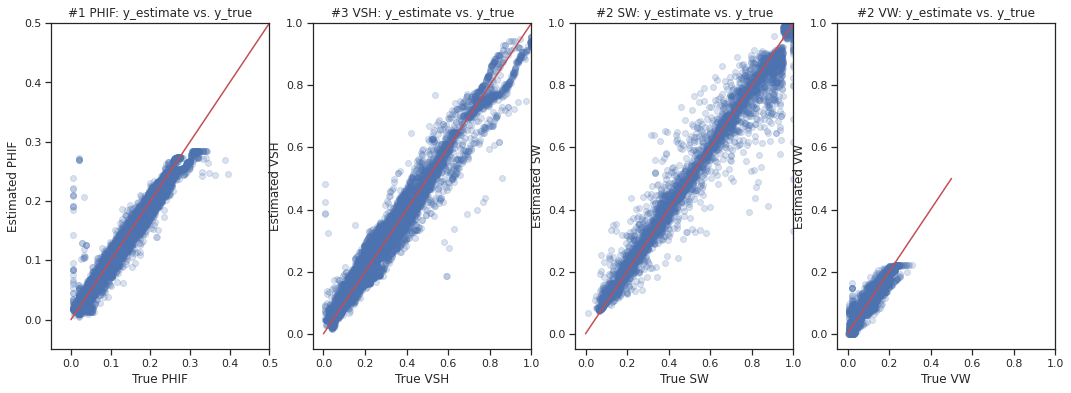

In [213]:
# cross validation and tests with XGBR
# SS_scaler = StandardScaler() # for all

# scaler = StandardScaler().fit(X_for_phif)
# SS_X_for_phif = scaler.transform(X_for_phif) # for X_for_phif
# SS_X_for_vsh = scaler.transform(X_for_vsh) # for X_for_vsh
# SS_X_for_sw = scaler.transform(X_for_sw) # for X_for_sw
# SS_X_for_vw = scaler.transform(X_for_vw) # for X_for_vw
# SS_X_for_submission = scaler.transform(df_new_test) # for df_new_test

# No scale
SS_X_for_phif = X_for_phif # for X_for_phif
SS_X_for_vsh = X_for_vsh # for X_for_vsh
SS_X_for_sw = X_for_sw # for X_for_sw
SS_X_for_vw = X_for_vw # for X_for_vw
SS_X_for_submission = X_for_submission # for df_new_test
SS_X_for_submission1 = X_for_submission1 # for df_new_test
SS_X_for_submission2 = X_for_submission2 # for df_new_test
SS_X_for_submission3 = X_for_submission3 # for df_new_test

# SS_X_for_phif = SS_scaler.fit_transform(X_for_phif) # for X_for_phif
# SS_X_for_vsh = SS_scaler.fit_transform(X_for_vsh) # for X_for_vsh
# SS_X_for_sw = SS_scaler.fit_transform(X_for_sw) # for X_for_sw
# SS_X_for_vw = SS_scaler.fit_transform(X_for_vw) # for X_for_vw

X_train_full_phif, X_test_phif, y_train_full_phif, y_test_phif = train_test_split(SS_X_for_phif, Y_for_phif, random_state=100, shuffle=True)
X_train_phif, X_val_phif, y_train_phif, y_val_phif = train_test_split(X_train_full_phif, y_train_full_phif, random_state=100, shuffle=True)
X_train_full_vsh, X_test_vsh, y_train_full_vsh, y_test_vsh = train_test_split(SS_X_for_vsh, Y_for_vsh, random_state=100, shuffle=True)
X_train_vsh, X_val_vsh, y_train_vsh, y_val_vsh = train_test_split(X_train_full_vsh, y_train_full_vsh, random_state=100, shuffle=True)
X_train_full_sw, X_test_sw, y_train_full_sw, y_test_sw = train_test_split(SS_X_for_sw, Y_for_sw, random_state=100, shuffle=True)
X_train_sw, X_val_sw, y_train_sw, y_val_sw = train_test_split(X_train_full_sw, y_train_full_sw, random_state=100, shuffle=True)
X_train_full_vw, X_test_vw, y_train_full_vw, y_test_vw = train_test_split(SS_X_for_vw, Y_for_vw, random_state=100, shuffle=True)
X_train_vw, X_val_vw, y_train_vw, y_val_vw = train_test_split(X_train_full_vw, y_train_full_vw, random_state=100, shuffle=True)

# xgbr_phif = xgb.XGBRegressor(subsample=0.7, n_estimators=1000, max_depth=20, learning_rate=0.01, colsample_bytree=0.7999999999999999, colsample_bylevel=0.8999999999999999, verbosity=0) # Lowest RMSE:  0.005788436336906936
# xgbr_phif = xgb.XGBRegressor(verbosity=0) # No tunning is better
xgbr_phif = xgb.XGBRegressor(n_estimators=1435, learning_rate=0.009, alpha=0.001968376844515574, reg_lambda=0.0017520167641233869, gamma=0, subsample=0.5015613448872586, colsample_bytree=0.7021490236008432, max_depth=1, max_features=0.9, min_child_weight=212, random_state=100, verbosity=0) # Best trial RMSE: 0.013013505511547604
# xgbr_vsh = xgb.XGBRegressor(subsample=0.6, n_estimators=500, max_depth=6, learning_rate=0.1, colsample_bytree=0.7999999999999999, colsample_bylevel=0.6, verbosity=0) # RMSE:  0.01749143832149558
# xgbr_vsh = xgb.XGBRegressor(subsample=0.7999999999999999, n_estimators=500, max_depth=20, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.8999999999999999, verbosity=0) # Lowest RMSE:  0.017293138061451885
# xgbr_vsh = xgb.XGBRegressor(subsample=0.7, n_estimators=3000, max_depth=6, learning_rate=0.01, colsample_bytree=0.7999999999999999, colsample_bylevel=0.6, verbosity=0)
# xgbr_vsh = xgb.XGBRegressor(subsample=0.5, n_estimators=3000, max_depth=15, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.6, verbosity=0)
# xgbr_vsh = xgb.XGBRegressor(subsample=0.7, n_estimators=4000, max_depth=6, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999, verbosity=0) 
xgbr_vsh = xgb.XGBRegressor(subsample=0.40203, n_estimators=1007, max_depth=1, learning_rate=0.02, alpha=1.43076, reg_lambda=0.00154, gamma=0, colsample_bytree=0.96207, max_features=7, min_child_weight=6, verbosity=0)
# xgbr_sw = xgb.XGBRegressor(subsample=0.8999999999999999, n_estimators=1000, max_depth=10, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.5, verbosity=0) # RMSE= 0.0370540519544373
# xgbr_sw = xgb.XGBRegressor(subsample=0.5, n_estimators=3000, max_depth=20, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999, verbosity=0)
# xgbr_sw = xgb.XGBRegressor(subsample=0.7, n_estimators=3000, max_depth=15, learning_rate=0.01, colsample_bytree=0.7999999999999999, colsample_bylevel=0.7999999999999999, verbosity=0)
xgbr_sw = xgb.XGBRegressor(subsample=0.7, n_estimators=400, max_depth=20, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.6, verbosity=0)
# xgbr_sw = xgb.XGBRegressor(n_estimators=399, learning_rate=0.02, alpha=0.023903833029769107, gamma=0, subsample=0.5252225641487763, colsample_bytree=0.7723592321738842, max_depth=2, max_features=0.9, min_child_weight=112, random_state=100) # SW Test dataset RMSE: 0.07607
# xgbr_vw = xgb.XGBRegressor(subsample=0.7, n_estimators=400, max_depth=20, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.6, verbosity=0)
# xgbr_vw = xgb.XGBRegressor(n_estimators=1196, learning_rate=0.05, alpha=0.011714093302114275, subsample=0.6477981389608624, colsample_bytree=0.6067816445514742, max_depth=1, max_features=0, min_child_weight=50, verbosity=0) # Best trial RMSE: 0.012142357606377704
# xgbr_vw = xgb.XGBRegressor(subsample=0.8999999999999999, n_estimators=200, min_child_weight=1, max_features=5, max_depth=5, learning_rate=0.1, colsample_bytree=0.7, colsample_bylevel=0.6, alpha=0, verbosity=0)
xgbr_vw = xgb.XGBRegressor(n_estimators=1121, learning_rate=0.02, alpha=0.04700334427842622, reg_lambda=0.3800359051857419, gamma=0, subsample=0.5013944972215499, colsample_bytree=0.3936302021972806, max_depth=1, max_features=0.9, min_child_weight=152, random_state=100)

print(xgbr_phif)
print(xgbr_vsh)
print(xgbr_sw)
print(xgbr_vw)

# Training models
xgbr_phif.fit(X_train_phif, y_train_phif)
xgbr_vsh.fit(X_train_vsh, y_train_vsh)
xgbr_sw.fit(X_train_sw, y_train_sw)
xgbr_vw.fit(X_train_vw, y_train_vw)
#  history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
#                     validation_data=(val_scaled, val_target))

score_train_phif = xgbr_phif.score(X_train_phif, y_train_phif)
score_train_vsh = xgbr_vsh.score(X_train_vsh, y_train_vsh)   
score_train_sw = xgbr_sw.score(X_train_sw, y_train_sw)
score_train_vw = xgbr_vw.score(X_train_vw, y_train_vw)   

print("PHIF Training score=", score_train_phif) 
print("VSH Training score: ", score_train_vsh) 
print("SW Training score: ", score_train_sw) 
print("VW Training score: ", score_train_vw) 

# cross validataion 
scores_val_phif = cross_val_score(xgbr_phif, X_val_phif, y_val_phif, cv=5)
scores_val_vsh = cross_val_score(xgbr_vsh, X_val_vsh, y_val_vsh, cv=5)
scores_val_sw = cross_val_score(xgbr_sw, X_val_sw, y_val_sw, cv=5)
scores_val_vw = cross_val_score(xgbr_vw, X_val_vw, y_val_vw, cv=5)
print("PHIF Mean cross-validation score: %.5f" % scores_val_phif.mean())
print("VSH Mean cross-validation score: %.5f" % scores_val_vsh.mean())
print("SW Mean cross-validation score: %.5f" % scores_val_sw.mean())
print("VW Mean cross-validation score: %.5f" % scores_val_vw.mean())

# Check Test data performance
ypred_phif = xgbr_phif.predict(X_test_phif)
ypred_vsh = xgbr_vsh.predict(X_test_vsh)
ypred_sw = xgbr_sw.predict(X_test_sw)
ypred_vw = xgbr_vw.predict(X_test_vw)

# Apply physical constraints
ypred_phif[ypred_phif < 0]=0
ypred_vsh[ypred_vsh < 0]=0
ypred_sw[ypred_sw < 0]=0
ypred_vw[ypred_vw < 0]=0
ypred_phif[ypred_phif > 0.4]=0.4
ypred_vsh[ypred_vsh > 1]=1
ypred_sw[ypred_sw > 1]=1
ypred_vw[ypred_vw > 1]=1

mse_phif = mean_squared_error(y_test_phif, ypred_phif)
mse_vsh = mean_squared_error(y_test_vsh, ypred_vsh)
mse_sw = mean_squared_error(y_test_sw, ypred_sw)
mse_vw = mean_squared_error(y_test_vw, ypred_vw)

print("PHIF Test dataset RMSE: %.5f" % (mse_phif**(1/2.0)))
print("VSH Test dataset RMSE: %.5f" % (mse_vsh**(1/2.0)))
print("SW Test dataset RMSE: %.5f" % (mse_sw**(1/2.0)))
print("VW Test dataset RMSE: %.5f" % (mse_vw**(1/2.0)))

plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.scatter(y_test_phif, ypred_phif, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated PHIF')
plt.xlabel('True PHIF')
plt.axis([-0.05, 0.5, -0.05, 0.5])
plt.title('#1 PHIF: y_estimate vs. y_true');
plt.subplot(142)
plt.scatter(y_test_vsh, ypred_vsh, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated VSH')
plt.xlabel('True VSH')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#3 VSH: y_estimate vs. y_true');
plt.subplot(143)
plt.scatter(y_test_sw, ypred_sw, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated SW')
plt.xlabel('True SW')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#2 SW: y_estimate vs. y_true');
plt.subplot(144)
plt.scatter(y_test_vw, ypred_vw, alpha=0.2)
plt.plot([0,0.5], [0,0.5], 'r')
plt.ylabel('Estimated VW')
plt.xlabel('True VW')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#2 VW: y_estimate vs. y_true');
plt.show()


In [214]:
def objectiveXGB(trial: Trial, X_train,  y_train, X_val, y_val):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 20, 2000),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.3), 
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'gamma' : trial.suggest_float('gamma', 0, 1.0), 
        'subsample' : trial.suggest_float('subsample', 0.2, 1.0), 
        # 'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.2, 1.0), 
        'max_depth' : trial.suggest_int('max_depth', 1, 30), 
        # 'max_features' : trial.suggest_categorical('max_features', [0.6, 0,7, 0.8, 0.9, 1.0]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        # 'random_state' : trial.suggest_categorical('random_state', [100])
    }
    model = XGBRegressor(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    kf_rmse = []
    test_preds = None
    for fold in enumerate(KFold(n_splits=5, shuffle=True).split(X_train,  y_train)):
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        kf_rmse.append(rmse)
        # if test_preds is None:
        #     test_preds = model.predict(X_val_phif)
        # else:
        #     test_preds = test_preds + model.predict(X_val_phif)
    rmse = np.mean(np.array(kf_rmse))
    return rmse

In [215]:
# study = optuna.create_study(sampler=TPESampler(seed=106), direction="minimize")
# study.optimize(lambda trial : objectiveXGB(trial, X_train_sw,  y_train_sw, X_val_sw, y_val_sw), n_trials=10, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)

In [216]:
def objectiveLGBR(trial: Trial, X_train,  y_train, X_val, y_val):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 20, 2000),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.3), 
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'gamma' : trial.suggest_float('gamma', 0, 1.0), 
        'subsample' : trial.suggest_float('subsample', 0.2, 1.0), 
        # 'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.2, 1.0), 
        'max_depth' : trial.suggest_int('max_depth', 1, 30), 
        # 'max_features' : trial.suggest_categorical('max_features', [0.6, 0,7, 0.8, 0.9, 1.0]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 30)
        # 'random_state' : trial.suggest_categorical('random_state', [100])
    }
    model = LGBMRegressor(**param)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    kf_rmse = []
    test_preds = None
    for fold in enumerate(KFold(n_splits=5, shuffle=True).split(X_train,  y_train)):
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        kf_rmse.append(rmse)
    rmse = np.mean(np.array(kf_rmse))
    return rmse

In [217]:
# study = optuna.create_study(sampler=TPESampler(seed=106), direction="minimize")
# study.optimize(lambda trial : objectiveLGBR(trial, X_train_vsh,  y_train_vsh, X_val_vsh, y_val_vsh), n_trials=30, gc_after_trial=True)
# print('Best trial param:', study.best_trial.params)
# print('Best trial RMSE:', study.best_trial.value)


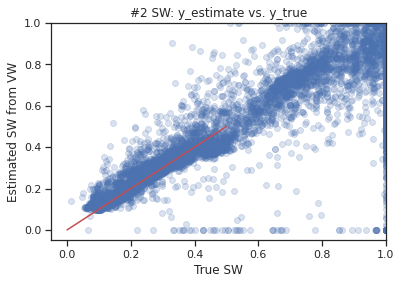

In [218]:
# Estimate SW (Water Saturation) from VW (Water Volume) using PHIF (Porosity)
ypred_sw4 = ypred_vw / ypred_phif
ypred_sw4[ypred_sw4 < 0]=0
ypred_sw4[ypred_sw4 > 1]=1
# ypred_sw4[ypred_phif2 < 0.05] = 1 # value from PHIF cutoff optimization

# rmse_sw = (mean_squared_error(y_test_sw, ypred_sw4))**0.5
# print("SW Test dataset RMSE: %.5f" % rmse_sw)

plt.scatter(y_test_sw, ypred_sw4, alpha=0.2)
plt.plot([0,0.5], [0,0.5], 'r')
plt.ylabel('Estimated SW from VW')
plt.xlabel('True SW')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#2 SW: y_estimate vs. y_true');
plt.show()

Streaming output truncated to the last 5000 lines.
[171]	validation_0-rmse:0.023196	validation_1-rmse:0.035905
[172]	validation_0-rmse:0.023149	validation_1-rmse:0.035901
[173]	validation_0-rmse:0.023096	validation_1-rmse:0.035902
[174]	validation_0-rmse:0.023055	validation_1-rmse:0.035896
[175]	validation_0-rmse:0.023019	validation_1-rmse:0.035889
[176]	validation_0-rmse:0.022966	validation_1-rmse:0.035874
[177]	validation_0-rmse:0.022932	validation_1-rmse:0.035879
[178]	validation_0-rmse:0.022906	validation_1-rmse:0.03588
[179]	validation_0-rmse:0.022861	validation_1-rmse:0.035926
[180]	validation_0-rmse:0.022828	validation_1-rmse:0.035957
[181]	validation_0-rmse:0.022779	validation_1-rmse:0.035937
[182]	validation_0-rmse:0.022734	validation_1-rmse:0.035905
[183]	validation_0-rmse:0.022705	validation_1-rmse:0.035912
[184]	validation_0-rmse:0.022686	validation_1-rmse:0.035916
[185]	validation_0-rmse:0.022649	validation_1-rmse:0.035916
[186]	validation_0-rmse:0.022608	validation_1-rmse

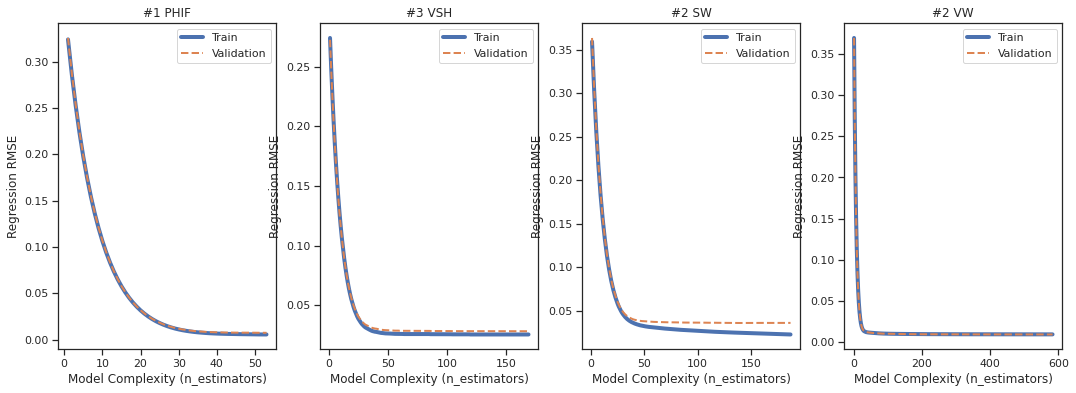

In [224]:
# SW estimation for avoiding overfitting
model_sw = XGBRegressor(
    n_jobs = -1,
    # subsample=0.55802, n_estimators=365, max_depth=6, learning_rate=0.009, alpha=0.00688, reg_lambda=0.40948, gamma=0,
    # colsample_bytree=0.89899, max_features=0.7, min_child_weight=219, verbosity=0, importance_type='total_cover'
    n_estimators=824, learning_rate=0.08423244614304505, alpha=0.04989653216697846, reg_lambda=2.3938918670661087, 
    gamma=0.004718856190972565, subsample=0.2972552966264914, max_depth=21, min_child_weight=9 # SW RMSE: 0.03741 
    # n_estimators=123, learning_rate=0.06634418978714522, alpha=0.00204043727641042, reg_lambda=0.0016380736536622585, 
    # gamma=0.004270540992121669, subsample=0.647032210674187, max_depth=8, min_child_weight=3 # SW RMSE: 0.03817
    # n_estimators=1496, learning_rate=0.23377582836036231, alpha=0.030074844502462596, reg_lambda=0.01809651050807897, 
    # gamma=0.005869993862694059, subsample=0.47197369642677767, max_depth=22, min_child_weight=1 # SW RMSE: 0.03909
    # n_estimators=893, learning_rate=0.1114340047778248, alpha=0.002420095353031345, reg_lambda=0.011692222974521355, 
    # gamma=0.21439832772463263, subsample=0.8511496706928927, max_depth=28, min_child_weight=5 # SW RMSE: 0.04185

)
model_sw2 = LGBMRegressor(
    n_jobs = -1,
    n_estimators=867, learning_rate=0.1673475536249245, alpha=0.0019166721687684102, reg_lambda=8.333731235680858, 
    gamma=0.6253883474227395, subsample=0.9477524395764764, max_depth=16, min_child_weight=6, num_leaves=21 # SW RMSE: 

)

eval_set_sw = [(X_train_sw, y_train_sw), 
            (X_val_sw, y_val_sw)]

model_sw.fit(X_train_sw, y_train_sw, 
          eval_set=eval_set_sw,
          eval_metric='rmse', 
          early_stopping_rounds=50
         ) 

model_sw2.fit(X_train_sw, y_train_sw, 
          eval_set=eval_set_sw,
          eval_metric='rmse', 
          early_stopping_rounds=50
         ) 

# VW estimation for avoiding overfitting
model_vw = XGBRegressor(
    n_jobs = -1,
    # subsample=0.55802, n_estimators=365, max_depth=6, learning_rate=0.009, alpha=0.00688, reg_lambda=0.40948, gamma=0,
    # colsample_bytree=0.89899, max_features=0.7, min_child_weight=219, verbosity=0
    # n_estimators=200, learning_rate=0.05, alpha=0.011714093302114275, gamma=0, 
    # subsample=0.6477981389608624, colsample_bytree=0.6067816445514742, max_depth=1, max_features=0, 
    # min_child_weight=50, verbosity=0
    # subsample=0.8999999999999999, n_estimators=500, min_child_weight=1, max_features=5, max_depth=5, learning_rate=0.1, 
    # colsample_bytree=0.7, colsample_bylevel=0.6, alpha=0, verbosity=0
    # n_estimators=1274, learning_rate=0.12510544837162355, alpha=3.111445414158237, reg_lambda=0.004314383497268784, gamma=0.00044002178109516735, 
    # subsample=0.876999775377684, max_depth=2, min_child_weight=7, importance_type='total_cover',
    # random_state=100
    # n_estimators=751, learning_rate=0.04903279847409485, alpha=0.01062409330140377, reg_lambda=0.01538275099224479, 
    # gamma=0.0004439270947214323, subsample=0.9463499732690696, max_depth=6, min_child_weight=9, random_state=100 # Best trial RMSE: 0.005180196243284739
    n_estimators=884, learning_rate=0.1396089183879156, alpha=4.387273238367252, reg_lambda=1.976767222562752, importance_type='total_cover',
    gamma=0.0025476093486937294, subsample=0.48525771140005214, max_depth=2, min_child_weight=7, random_state=100 # SW RMSE: 0.04185
    # n_estimators=53, learning_rate=0.11659538531088891, alpha=0.04509813811580201, reg_lambda=0.06744592168872512, 
    # gamma=0.0011123064302266108, subsample=0.5626795210748126, max_depth=18, min_child_weight=7, random_state=100, importance_type='total_cover' # SW RMSE: 0.04185

)

# Best trial RMSE: 0.012142357606377704
eval_set_vw = [(X_train_vw, y_train_vw), 
            (X_val_vw, y_val_vw)]

model_vw.fit(X_train_vw, y_train_vw, 
          eval_set=eval_set_vw,
          eval_metric='rmse', 
          early_stopping_rounds=50
         ) 

# VSH estimation for avoiding overfitting
model_vsh = XGBRegressor(
    n_jobs = -1,
    # subsample=0.7, n_estimators=1000, max_depth=6, learning_rate=0.01, 
    # colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999, verbosity=0
    # subsample=0.26393, n_estimators=92, max_depth=4, learning_rate=0.07, alpha=0.028289, reg_lambda=0.78778, gamma=0,
    # colsample_bytree=0.56197, max_features=0.5, min_child_weight=58, verbosity=0
    # subsample=0.47294, n_estimators=838, max_depth=2, learning_rate=0.084232, alpha=0.049896, reg_lambda=2.39389, gamma=0.00472,
    # min_child_weight=9, verbosity=0, importance_type='total_cover'
    # n_estimators=533, learning_rate=0.089509, alpha=0.30691, reg_lambda=1.50022, gamma=0.00488, 
    # subsample=0.46743, max_depth=16, min_child_weight=5, random_state=100, importance_type='gain' # test trial RMSE: 0.006609
    n_estimators=1146, learning_rate=0.09369279525691428, alpha=0.02433127225240888, reg_lambda=0.025530497042690458, 
    gamma=0.14546685649615498, subsample=0.9781317477739602, max_depth=28, min_child_weight=6, importance_type='total_gain' # VSH RMSE: 0.02905
    # n_estimators=572, learning_rate=0.03035958995966467, alpha=0.0014312631387369676, reg_lambda=0.005619630017586593, 
    # gamma=0.13846756775440772, subsample=0.4724899501919733, max_depth=30, min_child_weight=2, importance_type='total_gain' # VSH RMSE: 0.02971
    # n_estimators=1357, learning_rate=0.06328029650350778, alpha=0.08857692821460467, reg_lambda=0.8978739688273313, 
    # gamma=0.0007763994537385993, subsample=0.2000948539925908, max_depth=25, min_child_weight=3 # VSH RMSE: 0.02277
    # n_estimators=1184, learning_rate=0.11499273649005878, alpha=0.4149137542851107, reg_lambda=0.0010333874842604917, 
    # gamma=0.012170511931676675, subsample=0.4974700258753041, max_depth=3, min_child_weight=2 # VSH RMSE: 0.02675
    # n_estimators=1472, learning_rate=0.06713571014617287, alpha=0.0057747552926682415, reg_lambda=0.0011817756570782344, 
    # gamma=0.0025450957545167757, subsample=0.5150626685251101, max_depth=23, min_child_weight=1 # VSH RMSE: 0.02425

)
model_vsh2 = LGBMRegressor(
    n_jobs = -1,
    n_estimators=1353, learning_rate=0.11388055817731939, alpha=0.008445583573237063, reg_lambda=2.200942891596056, 
    gamma=0.5635460456097597, subsample=0.8669810064673875, max_depth=23, min_child_weight=10, num_leaves=25

)

eval_set_vsh = [(X_train_vsh, y_train_vsh), 
            (X_val_vsh, y_val_vsh)]

model_vsh.fit(X_train_vsh, y_train_vsh, 
          eval_set=eval_set_vsh,
          eval_metric='rmse', # 
          early_stopping_rounds=50
         ) 
model_vsh2.fit(X_train_vsh, y_train_vsh, 
          eval_set=eval_set_vsh,
          eval_metric='rmse', # 
          early_stopping_rounds=50
         ) 

# PHIF estimation for avoiding overfitting
model_phif = XGBRegressor(
    n_jobs = -1,
    # n_estimators=884, learning_rate=0.13961, alpha=4.3873, reg_lambda=1.97676, gamma=0.00255, subsample=0.48526, 
    # max_depth=2, min_child_weight=7, random_state=100, verbosity=0, importance_type='total_cover'
    n_estimators=53, learning_rate=0.11659, alpha=0.04509813811580201, reg_lambda=0.06744592168872512, gamma=0.0011123064302266108, 
    subsample=0.5626795210748126, max_depth=18, min_child_weight=7, random_state=100, importance_type='total_cover' # PHIF RMSE: 0.00750
    # n_estimators=824, learning_rate=0.08423244614304505, alpha=0.04989653216697846, reg_lambda=2.3938918670661087, 
    # gamma=0.004718856190972565, subsample=0.2972552966264914, max_depth=21, min_child_weight=9, importance_type='total_cover' # PHIF RMSE: 0.00875
    # n_estimators=455, learning_rate=0.26914843611611033, alpha=0.013654708580748366, reg_lambda=0.007302009228503428, 
    # gamma=0.028506959018591127, subsample=0.22828918554252528, max_depth=27, min_child_weight=10, importance_type='total_cover' # PHIF RMSE: 0.01136
    # n_estimators=1214, learning_rate=0.2985406764530442, alpha=0.09733512543136344, reg_lambda=0.001107165796732986, 
    # gamma=0.019036313869628285, subsample=0.5065289533688904, max_depth=3, min_child_weight=1 # PHIF RMSE: 0.01052
    # n_estimators=893, learning_rate=0.1114340047778248, alpha=0.002420095353031345, reg_lambda=0.011692222974521355, 
    # gamma=0.21439832772463263, subsample=0.8511496706928927, max_depth=28, min_child_weight=5 # PHIF RMSE: 0.01290
  
  )
model_phif2 = LGBMRegressor(
    n_jobs = -1,
    n_estimators=1991, learning_rate=0.1673475536249245, alpha=0.5795719610185958, reg_lambda=8.333731235680858, 
    gamma=0.12754447680439202, subsample=0.9477524395764764, max_depth=16, min_child_weight=5, num_leaves=9 # PHIF RMSE: 
  
  )

eval_set_phif = [(X_train_phif, y_train_phif), (X_val_phif, y_val_phif)]

model_phif.fit(X_train_phif, y_train_phif, 
          eval_set=eval_set_phif,
          eval_metric='rmse', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) 
model_phif2.fit(X_train_phif, y_train_phif, 
          eval_set=eval_set_phif,
          eval_metric='rmse', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) 

results_phif = model_phif.evals_result()
train_error_phif = results_phif['validation_0']['rmse']
val_error_phif = results_phif['validation_1']['rmse']

results_vsh = model_vsh.evals_result()
train_error_vsh = results_vsh['validation_0']['rmse']
val_error_vsh = results_vsh['validation_1']['rmse']

results_sw = model_sw.evals_result()
train_error_sw = results_sw['validation_0']['rmse']
val_error_sw = results_sw['validation_1']['rmse']


results_vw = model_vw.evals_result()
train_error_vw = results_vw['validation_0']['rmse']
val_error_vw = results_vw['validation_1']['rmse']

epoch_phif = range(1, len(train_error_phif)+1)
epoch_vsh = range(1, len(train_error_vsh)+1)
epoch_sw = range(1, len(train_error_sw)+1)
epoch_vw = range(1, len(train_error_vw)+1)

plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.plot(epoch_phif, train_error_phif, label='Train', linewidth=4)
plt.plot(epoch_phif, val_error_phif, '--', linewidth=2, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();
plt.title('#1 PHIF');
plt.subplot(142)
plt.plot(epoch_vsh, train_error_vsh, label='Train', linewidth=4)
plt.plot(epoch_vsh, val_error_vsh, '--', linewidth=2, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();
plt.title('#3 VSH');
plt.subplot(143)
plt.plot(epoch_sw, train_error_sw, label='Train', linewidth=4)
plt.plot(epoch_sw, val_error_sw, '--', linewidth=2, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();
plt.title('#2 SW');
plt.subplot(144)
plt.plot(epoch_vw, train_error_vw, label='Train', linewidth=4)
plt.plot(epoch_vw, val_error_vw, '--', linewidth=2, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();
plt.title('#2 VW');
plt.show()

(array([1.020e+02, 1.126e+03, 1.497e+03, 9.690e+02, 8.330e+02, 8.740e+02,
        8.590e+02, 7.920e+02, 6.150e+02, 5.710e+02, 4.010e+02, 2.660e+02,
        2.540e+02, 1.890e+02, 1.810e+02, 1.350e+02, 1.680e+02, 1.840e+02,
        1.810e+02, 1.390e+02, 5.800e+01, 4.700e+01, 3.600e+01, 2.000e+01,
        1.000e+01, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([0.00255711, 0.01276971, 0.0229823 , 0.0331949 , 0.0434075 ,
        0.0536201 , 0.06383269, 0.07404529, 0.08425789, 0.09447049,
        0.10468308, 0.11489568, 0.12510828, 0.13532088, 0.14553347,
        0.15574607, 0.16595867, 0.17617127, 0.18638387, 0.19659646,
        0.20680906, 0.21702166, 0.22723426, 0.23744685, 0.24765945,
        0.25787205, 0.26808465, 0.27829724, 0.28850984, 0.29872244,
        0.30893504]),
 <a list of 30 Patch objects>)

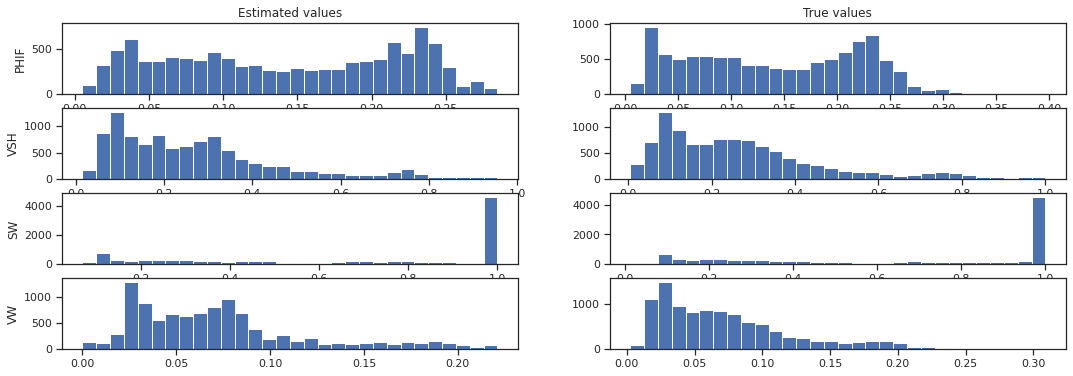

In [225]:
plt.figure(figsize=(18, 6))
plt.subplot(421)
plt.hist(ypred_phif, density=False, bins=30)  # density=False would make counts
plt.title('Estimated values');
plt.ylabel('PHIF')
plt.subplot(422)
plt.hist(y_test_phif, density=False, bins=30)  # density=False would make counts
plt.title('True values');
plt.subplot(423)
plt.hist(ypred_vsh, density=False, bins=30)  # density=False would make counts
plt.ylabel('VSH')
plt.subplot(424)
plt.hist(y_test_vsh, density=False, bins=30)  # density=False would make counts
plt.subplot(425)
plt.hist(ypred_sw, density=False, bins=30)  # density=False would make counts
plt.ylabel('SW')
plt.subplot(426)
plt.hist(y_test_sw, density=False, bins=30)  # density=False would make counts
plt.subplot(427)
plt.hist(ypred_vw, density=False, bins=30)  # density=False would make counts
plt.ylabel('VW')
plt.subplot(428)
plt.hist(y_test_vw, density=False, bins=30)  # density=False would make counts


In [226]:
# ypred_phif2.max(), y_test_phif.max()

PHIF RMSE: 0.00654
VSH RMSE: 0.02393
SW RMSE: 0.03670
VW RMSE: 0.08587
total_RMSE:  0.02557285358185912


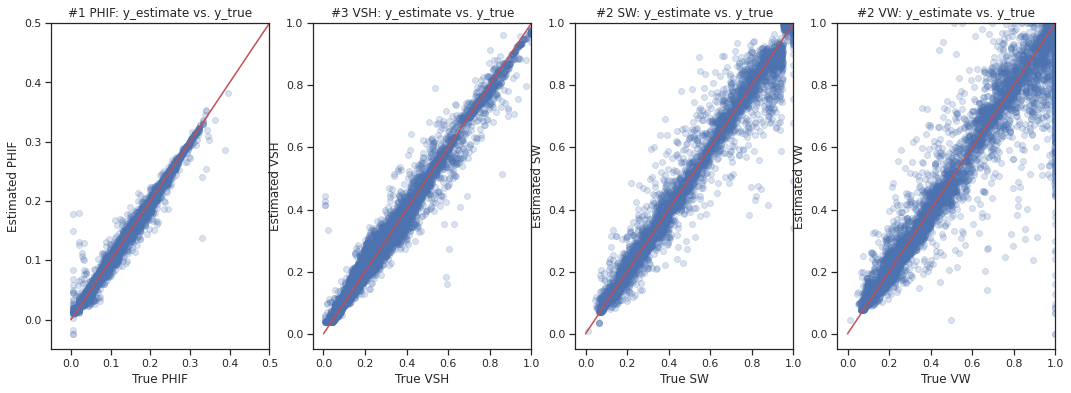

In [227]:
# Check Test data performance

# # Check Test data performance
# ypred_phif = xgbr_phif.predict(X_test_phif)
# ypred_vsh = xgbr_vsh.predict(X_test_vsh)
# ypred_sw = xgbr_sw.predict(X_test_sw)
# ypred_vw = xgbr_vw.predict(X_test_vw)

ypred_phif2 = model_phif.predict(X_test_phif)
ypred_vsh2 = model_vsh.predict(X_test_vsh)
ypred_sw2 = model_sw.predict(X_test_sw)
ypred_phif4 = model_phif2.predict(X_test_phif)
ypred_vsh4 = model_vsh2.predict(X_test_vsh)
ypred_sw4 = model_sw2.predict(X_test_sw)

ypred_vw2 = model_vw.predict(X_test_vw)

ypred_sw3 = ypred_vw2/ypred_phif2
# ypred_sw3 = ypred_vw2/y_test_phif
ypred_sw3[ypred_phif2<0.001]=1 # value from PHIF cutoff optimization
ypred_sw3[ypred_sw3>1]=1
ypred_sw3[ypred_sw3<0]=0

ypred_phif_avg = (ypred_phif2 + ypred_phif4) / 2
ypred_vsh_avg = (ypred_vsh2 + ypred_vsh4) / 2
ypred_sw_avg = (ypred_sw2 + ypred_sw4) / 2

mse_phif2 = mean_squared_error(y_test_phif, ypred_phif_avg)
mse_vsh2 = mean_squared_error(y_test_vsh, ypred_vsh_avg)
mse_sw2 = mean_squared_error(y_test_sw, ypred_sw_avg)
mse_vw2 = mean_squared_error(y_test_sw, ypred_sw3)

print("PHIF RMSE: %.5f" % (mse_phif2**(1/2.0)))
print("VSH RMSE: %.5f" % (mse_vsh2**(1/2.0)))
print("SW RMSE: %.5f" % (mse_sw2**(1/2.0)))
print("VW RMSE: %.5f" % (mse_vw2**(1/2.0)))
total_blind_RMSE = ((mse_phif2 + mse_vsh2 + mse_sw2)/3)**0.5
print("total_RMSE: ", total_blind_RMSE)

plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.scatter(y_test_phif, ypred_phif2, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated PHIF')
plt.xlabel('True PHIF')
plt.axis([-0.05, 0.5, -0.05, 0.5])
plt.title('#1 PHIF: y_estimate vs. y_true');
plt.subplot(142)
plt.scatter(y_test_vsh, ypred_vsh2, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated VSH')
plt.xlabel('True VSH')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#3 VSH: y_estimate vs. y_true');
plt.subplot(143)
plt.scatter(y_test_sw, ypred_sw2, alpha=0.2)
plt.plot([0,1], [0,1], 'r')
plt.ylabel('Estimated SW')
plt.xlabel('True SW')
plt.axis([-0.05, 1, -0.05, 1])
plt.title('#2 SW: y_estimate vs. y_true');
plt.subplot(144)
plt.scatter(y_test_sw, ypred_sw3, alpha=0.2)
plt.plot([0,1.0], [0,1.0], 'r')
plt.ylabel('Estimated VW')
plt.xlabel('True VW')
plt.axis([-0.05, 1.0, -0.05, 1.0])
plt.title('#2 VW: y_estimate vs. y_true');
plt.show()

Text(0, 0.5, 'y_test_sw')

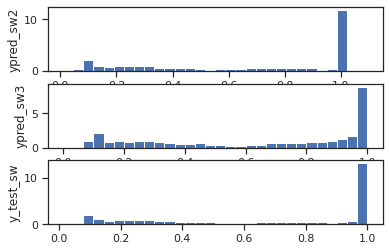

In [228]:
plt.subplot(311)
plt.hist(ypred_sw2, density=True, bins=30)  # density=False would make counts
plt.ylabel('ypred_sw2')
plt.subplot(312)
plt.hist(ypred_sw3, density=True, bins=30)  # density=False would make counts
plt.ylabel('ypred_sw3')
plt.subplot(313)
plt.hist(y_test_sw, density=True, bins=30)  # density=False would make counts
plt.ylabel('y_test_sw')

min POR cutoff is  0.03899999999999998


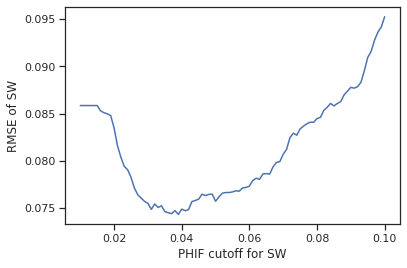

In [229]:
# find the optimized phif cutoff for Sw
ypred_vw2 = model_vw.predict(X_test_vw)
ypred_sw3 = ypred_vw2/ypred_phif2
cutoffs = np.arange(0.01, 0.1, 0.001)

rmse_cutoff = []
for i in cutoffs:
  ypred_sw3[ypred_phif2 < i] = 1
  ypred_sw3[ypred_sw3>1]=1
  ypred_sw3[ypred_sw3<0]=0
  rmse_vw_cutoff = (mean_squared_error(y_test_sw, ypred_sw3))**0.5
  rmse_cutoff.append(rmse_vw_cutoff)

plt.plot(cutoffs, rmse_cutoff)
plt.xlabel('PHIF cutoff for SW')
plt.ylabel('RMSE of SW')
print("min POR cutoff is ", cutoffs[np.argmin(rmse_cutoff)])


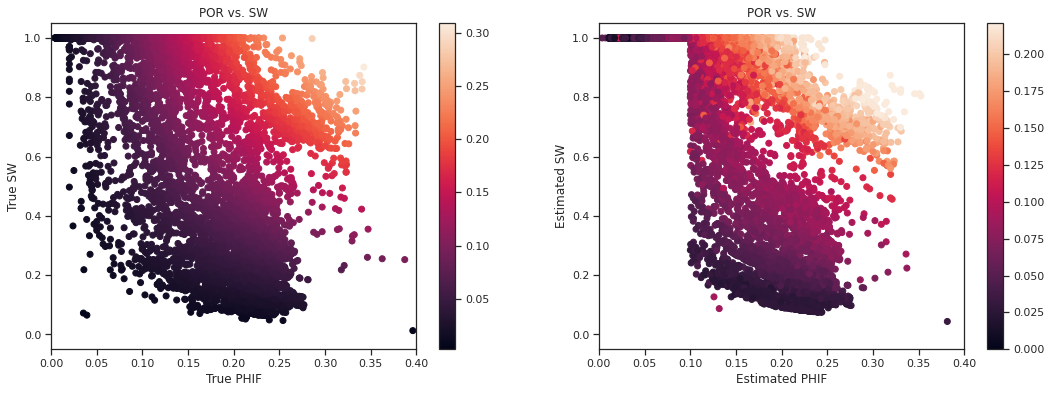

In [230]:
# plt.scatter(ypred_phif2, ypred_sw3, alpha=0.2, c=y_test_phif)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.scatter(y_test_phif, y_test_sw, c=y_test_vw)
plt.ylabel('True SW')
plt.xlabel('True PHIF')
plt.axis([0, 0.4, -0.05, 1.05])
plt.title('POR vs. SW');
plt.colorbar()
plt.subplot(122)
plt.scatter(ypred_phif2, ypred_sw3, c=ypred_vw)
plt.ylabel('Estimated SW')
plt.xlabel('Estimated PHIF')
plt.axis([0, 0.4, -0.05, 1.05])
plt.title('POR vs. SW');
plt.colorbar()
plt.show()

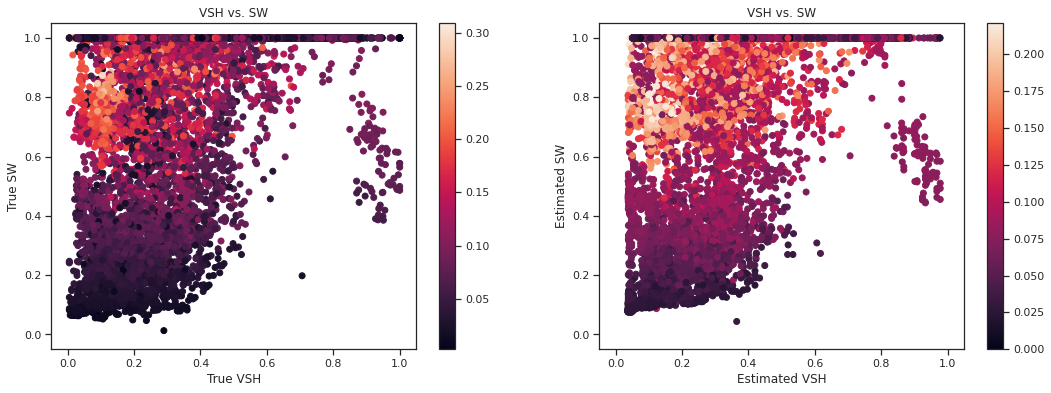

In [231]:
# plt.scatter(ypred_phif2, ypred_sw3, alpha=0.2, c=y_test_phif)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.scatter(y_test_vsh, y_test_sw, c=y_test_vw)
plt.ylabel('True SW')
plt.xlabel('True VSH')
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('VSH vs. SW');
plt.colorbar()
plt.subplot(122)
plt.scatter(ypred_vsh2, ypred_sw3, c=ypred_vw)
plt.ylabel('Estimated SW')
plt.xlabel('Estimated VSH')
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('VSH vs. SW');
plt.colorbar()
plt.show()

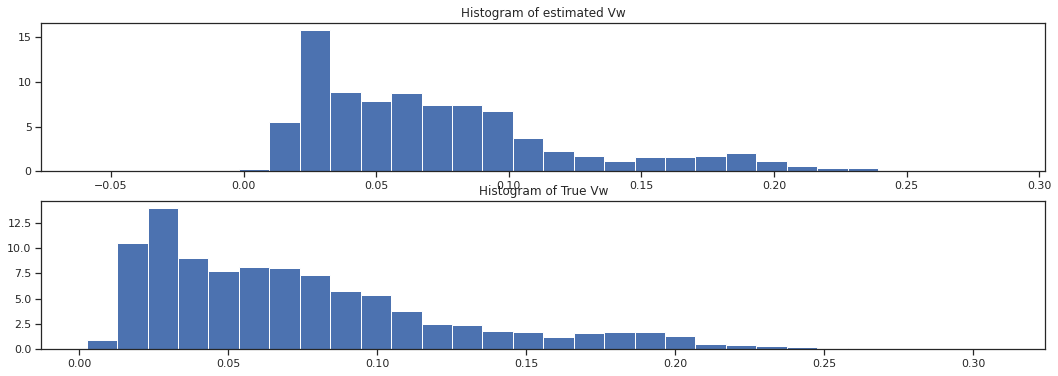

In [232]:
plt.figure(figsize=(18, 6))
plt.subplot(211)
plt.hist(ypred_vw2, density=True, bins=30)  # density=False would make counts
plt.title('Histogram of estimated Vw');
plt.subplot(212)
plt.hist(y_test_vw, density=True, bins=30)  # density=False would make counts
plt.title('Histogram of True Vw');

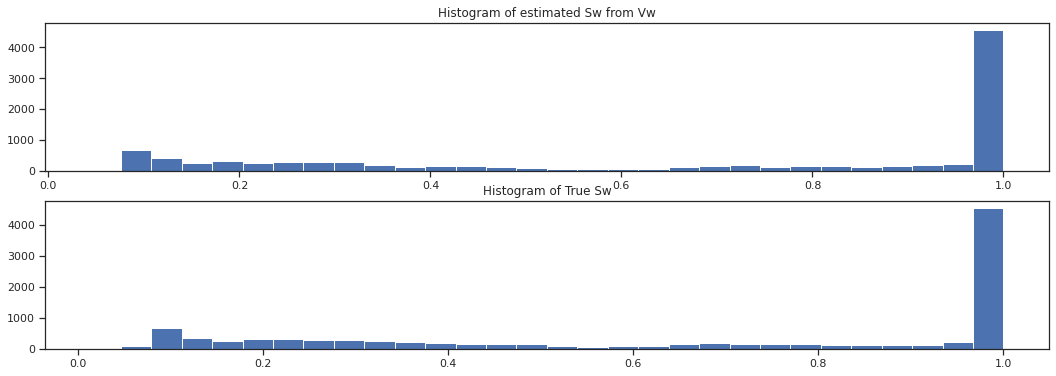

In [233]:
plt.figure(figsize=(18, 6))
plt.subplot(211)
plt.hist(ypred_sw3, density=False, bins=30)  # density=False would make counts
plt.title('Histogram of estimated Sw from Vw');
plt.subplot(212)
plt.hist(y_test_sw, density=False, bins=30)  # density=False would make counts
plt.title('Histogram of True Sw');

In [234]:
# Stacking or Blending models to predict


In [245]:
# Making prediction submission.csv file
pred_phif_test = model_phif.predict(SS_X_for_submission1)
pred_vsh_test = model_vsh.predict(SS_X_for_submission2)
pred_sw_test = model_sw.predict(SS_X_for_submission3)
pred_phif_test2 = model_phif2.predict(SS_X_for_submission1)
pred_vsh_test2 = model_vsh2.predict(SS_X_for_submission2)
pred_sw_test2 = model_sw2.predict(SS_X_for_submission3)

pred_vw_test = model_vw.predict(SS_X_for_submission3)

pred_sw_test_final = pred_vw_test/pred_phif_test
pred_sw_test_final[pred_phif_test < 0.029] = 1 # value from PHIF cutoff optimization
pred_sw_test_final[pred_sw_test_final > 1] = 1
pred_sw_test_final[pred_sw_test_final < 0] = 0

ypred_phif_submission = pd.DataFrame((pred_phif_test+pred_phif_test2)/2, columns=['PHIF'])
ypred_vsh_submission = pd.DataFrame((pred_vsh_test+pred_vsh_test2)/2, columns=['VSH'])
ypred_sw_submission = pd.DataFrame((pred_sw_test+pred_sw_test2)/2, columns=['SW'])
# ypred_sw_submission = pd.DataFrame(pred_sw_test_final, columns=['SW'])
# ypred_vw_submission = pd.DataFrame(pred_vw_test, columns=['VW'])
# ypred_sw_submission_new['SW'] = ypred_vw_submission['VW'] / ypred_phif_submission['PHIF']

test_predict_submission = pd.concat([ypred_phif_submission , ypred_sw_submission, ypred_vsh_submission], axis=1)
test_predict_submission.loc[test_predict_submission['PHIF'] < 0,'PHIF']= 0
test_predict_submission.loc[test_predict_submission['SW'] > 1,'SW']= 1
test_predict_submission.loc[test_predict_submission['VSH'] > 1,'VSH']= 1
test_predict_submission.loc[test_predict_submission['SW'] < 0,'SW']= 0
test_predict_submission.loc[test_predict_submission['VSH'] < 0,'VSH']= 0

# Replace team_name and num_submit
team_name = 'dirty_cats'
num_submit = 3

# Please don't change codes below
N_SAMPLES = 11275
n_sub_dict = {1:1, 2:2, 3:3}

# Check submission number is correct
try:
    n_sub = n_sub_dict[num_submit]
except KeyError:
    print(f"ERROR!!! Sumbmission Number must be in 1, 2 or 3")

# Check number of samples are correct
if test_predict_submission.shape[0] != N_SAMPLES:
    raise ValueError(f"Number of samples {test_predict_submission.shape[0]} doesn't matches with the correct value {N_SAMPLES}")

# Write results to csv file
# output_result = pd.DataFrame({col_names[-3]:test_predict[:,0], col_names[-2]:test_predict[:,1], col_names[-1]:test_predict[:,2]})
output_result = test_predict_submission
output_result.to_csv(path_or_buf=f'./{team_name}_{n_sub}.csv', index=False)


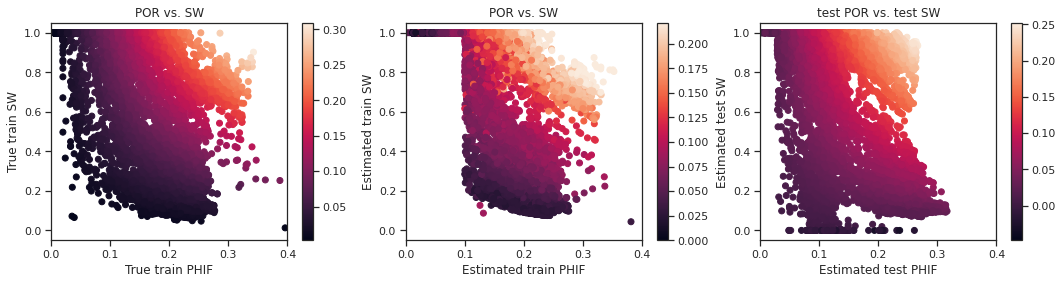

In [246]:
# checking final test dataset prediction results
# plt.scatter(ypred_phif2, ypred_sw3, alpha=0.2, c=y_test_phif)
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(y_test_phif, y_test_sw, c=y_test_vw)
plt.ylabel('True train SW')
plt.xlabel('True train PHIF')
plt.axis([0, 0.4, -0.05, 1.05])
plt.title('POR vs. SW');
plt.colorbar()
plt.subplot(132)
plt.scatter(ypred_phif2, ypred_sw3, c=ypred_vw)
plt.ylabel('Estimated train SW')
plt.xlabel('Estimated train PHIF')
plt.axis([0, 0.4, -0.05, 1.05])
plt.title('POR vs. SW');
plt.colorbar()
plt.subplot(133)
plt.scatter(pred_phif_test, pred_sw_test_final, c=pred_vw_test)
plt.ylabel('Estimated test SW')
plt.xlabel('Estimated test PHIF')
plt.axis([0, 0.4, -0.05, 1.05])
plt.title('test POR vs. test SW');
plt.colorbar()
plt.show()

In [237]:
stophere

In [238]:
# # dt = DecisionTreeClassifier()
# xgbr = xgb.XGBRegressor(seed = 100)
# params = { max_depth: [1,2,3,4,5],
#            learning_rate: [0.001, 0.01, 0.1],
#            subsample: np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 200, 300, 400, 500],
#            'alpha': [0, 0.33, 0.66, 1],
#            'max_features': [1,2,3,4,5],
#            'min_child_weight': [0.1, 1],
#           }

# n_iter = 20
# rs = RandomizedSearchCV(xgbr,
#                         param_distributions=params,
#                         n_iter=n_iter, 
#                         cv=5, 
#                         n_jobs=-1)
# rs.fit(X_train_full_vw, y_train_full_vw)


# print("Best parameters:", rs.best_params_)
# print("Lowest RMSE: ", (-rs.best_score_)**(1/2.0))
# pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
# pd.DataFrame(rs.cv_results_)

# Best parameters: {'subsample': 0.6, 'n_estimators': 3000, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
# Lowest RMSE:  nan

# SW
# subsample=0.7999999999999999, n_estimators=500, max_depth=20, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.8999999999999999}
# Lowest RMSE:  0.017293138061451885
# VW
# subsample=0.8999999999999999, n_estimators=500, min_child_weight=1, max_features=5, max_depth=5, learning_rate=0.1, colsample_bytree=0.7, colsample_bylevel=0.6, alpha=0



In [239]:
# rs.best_params_

In [240]:
# params = { 'max_depth': [2, 4, 6, 10, 15, 20],
#            'learning_rate': [0.001, 0.01, 0.1, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000]}
# xgbr = xgb.XGBRegressor(seed = 100)
# clf = RandomizedSearchCV(estimator=xgbr,
#                          param_distributions=params,
#                          scoring='neg_mean_squared_error',
#                          n_iter=25,
#                          verbose=1)
# clf.fit(X_train_phif, y_train_phif) 
# # X_val_sw, y_val_sw

# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [241]:
#XGBoost hyper-parameter tuning
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.0001, 0.001, 0.01],
#         'max_depth': [3, 5, 7, 9],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [100, 200, 500],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = XGBRegressor()
#     gsearch = GridSearchCV(estimator = xgb_model,
#                             param_grid = param_tuning,                        
#                             #scoring = 'neg_mean_absolute_error', #MAE
#                             #scoring = 'neg_mean_squared_error',  #MSE
#                             cv = 5,
#                             n_jobs = -1,
#                             verbose = 1)

#     gsearch.fit(X_train_full_sw, y_train_full_sw)
#     return gsearch.best_params_

# #Run only in the first run of the kernel.
# hyperParameterTuning(X_train_full_sw, y_train_full_sw)


In [242]:
# # Apply the best hyperparameters found from GridSearch
# xgb_model = XGBRegressor(
#         objective = 'reg:squarederror',
#         colsample_bytree = 0.5,
#         learning_rate = 0.05,
#         max_depth = 6,
#         min_child_weight = 1,
#         n_estimators = 1000,
#         subsample = 0.7)

# %time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
# y_pred_xgb = xgb_model.predict(X_val)
# mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# print("MAE: ", mae_xgb)
# X_test = test_005
# # Use the model to make predictions
# y_pred_test = xgb_model.predict(X_test)
# submission = pd.DataFrame({'Id':test_id,'SalePrice':y_pred_test})

# # Save results
# submission.to_csv("submission.csv",index=False)


In [243]:
gc.collect()
# X_train_phif, X_val_phif, y_train_phif, y_val_phif = train_test_split(X_train_full_phif, y_train_full_phif
#        , , ,  = train_test_split(X_train_full_phif, y_train_full_phif

PHIF_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_PHIF', 'TRAIN SCORE', 'VAL SCORE'])
PHIF_model_score.style.set_precision(5)
for name, estimator in ESTIMATORS_PHIF.items():
    print(name)
    estimator.fit(X_train_phif, y_train_phif)
    pred = estimator.predict(X_val_phif)
    y_train_for_phif_numpy = y_train_phif.copy().to_numpy()
    y_val_for_phif_numpy = y_val_phif.copy().to_numpy()
    RMSE_PHIF = np.sqrt(mean_squared_error(y_val_for_phif_numpy, pred))
    print('  RMSE_PHIF:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_phif_numpy, pred))))
    # score_train = estimator.score(X_train_for_phif, y_train_for_phif_numpy) # train set accuracy    
    # score_val = estimator.score(X_val_phif, y_val_for_phif_numpy) # val set accuracy
    # score_train = cross_val_score(estimator, X_train_for_phif, y_train_for_phif, scoring='r2' ,cv=kfold).mean()
    # score_val = cross_val_score(estimator, X_train_for_phif, y_train_for_phif, scoring='r2',cv=kfold).mean()
    # print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))
    PHIF_model_score = PHIF_model_score.append(pd.DataFrame([[name, RMSE_PHIF, score_train, score_val]], columns=['MODEL', 'RMSE_PHIF', 'TRAIN SCORE', 'VAL SCORE']))
    PHIF_model_score.set_index('MODEL', inplace=False)

CatBoostRegressor
  RMSE_PHIF: 0.00631
GradientBoostingRegressor


ValueError: ignored

In [ ]:
PHIF_model_score.T.index=['MODEL', 'RMSE_PHIF', 'TRAIN SCORE', 'VAL SCORE']
PHIF_model_score.sort_values(by=['RMSE_PHIF'], ascending = True)

In [ ]:
del [[name, estimator, score_train, score_val]]
del [[PHIF_model_score]]
gc.collect()

In [ ]:
# Best trial param={'max_depth': 6, 'learning_rate': 0.02, 'min_child_samples': 3, 'subsample': 0.9169382911878344, 'n_estimators': 710, 'l2_leaf_reg': 1.0, 'random_state': 100}
# Best trial RMSE: 0.04014199401503939
model21 = xgb.XGBRegressor(n_estimators= 1793, learning_rate= 0.006, alpha= 0.12523109217078937, gamma= 0, subsample= 0.6703396369347127, colsample_bytree= 0.9840638396307503, max_depth= 20, max_features= 7, min_child_weight= 1, random_state= 100)
# model22 = GradientBoostingRegressor(n_estimators=2000, max_depth=10, min_samples_split=3, min_samples_leaf=3, subsample=0.5, random_state=100, learning_rate=0.055)
# model23 = HistGradientBoostingRegressor(max_depth= 20, learning_rate= 0.1, max_leaf_nodes= 91, min_samples_leaf= 15, max_bins= 194, validation_fraction= 0.10423533908483208, max_iter= 538, n_iter_no_change= 39, random_state= 100)
# model24 = lgbm.LGBMRegressor(min_child_weight= 0.009, random_state= 100, colsample_bytree= 0.9300771838791059, max_depth= 12, learning_rate= 0.015, n_estimators= 4066, min_child_samples= 45, subsample= 0.4092442539745719, num_leaves= 20)
# model25 = CatBoostRegressor(learning_rate= 0.015, min_child_samples= 41, subsample= 0.7098549431920937, n_estimators= 3426, random_state= 100, eval_metric = 'RMSE', loss_function = 'RMSE', verbose=False)
# model26 = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=None, criterion ='mse', max_features='auto', splitter = 'best'), n_estimators = 300, verbose = 0, random_state=100)
# model27 = RandomForestRegressor(random_state=100, n_estimators=100)

In [ ]:
model21 = model21.fit(X_train_for_phif, y_train_for_phif)
pred_phif = model21.predict(df_new_test)
pred_phif = pd.DataFrame(pred_phif, columns=['PHIF'])
# model22 = model22.fit(X_train_for_phif, y_train_for_phif)
# model23 = model23.fit(X_train_for_phif, y_train_for_phif)
# model24 = model24.fit(X_train_for_phif, y_train_for_phif)
# model25 = model25.fit(X_train_for_phif, y_train_for_phif)
# model26 = model26.fit(X_train_for_phif, y_train_for_phif)
# model27 = model27.fit(X_train_for_phif, y_train_for_phif)

In [ ]:
# !pip install eli5
# import eli5
# from eli5.sklearn import PermutationImportance
# perm = PermutationImportance(model21, scoring="f1", random_state=100).fit(X_val_for_phif, y_val_for_phif)
# eli5.show_weights(perm, feature_names = X_for_phif.columns.tolist())

In [ ]:
import xgboost
# model21.feature_names = ['WELLNUM', 'DEPTH', 'BS', 'CALI', 'DEN', 'DENC', 'GR', 'NEU', 'PEF', 'RDEP', 'RMED', 'ROP']
# model21.feature_names = np.array(X_for_phif.columns)
# xgboost.plot_importance(model21, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model21, importance_type='cover', title='cover')
# pyplot.show()
# xgboost.plot_importance(model21, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model21, importance_type='total_gain', title='total_gain')
# pyplot.show()
# xgboost.plot_importance(model21, importance_type='total_cover', title='total_cover')
# pyplot.show()

In [ ]:
# from sklearn.ensemble import VotingRegressor
# voting_model = VotingRegressor([('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5)], n_jobs=-1, weights=[5,4,3,2,1])
# voting_model.fit(X_train_for_phif, y_train_for_phif)
# pred = voting_model.predict(X_val_for_phif)
# y_train_for_phif_numpy = y_train_for_phif.copy().to_numpy()
# y_val_for_phif_numpy = y_val_for_phif.copy().to_numpy()
# print('  RMSE_PHIF:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_phif_numpy, pred))))
# score_train = voting_model.score(X_train_for_phif, y_train_for_phif_numpy) # train set accuracy    
# score_val = voting_model.score(X_val_for_phif, y_val_for_phif_numpy) # val set accuracy
# print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))

In [ ]:
# from mlxtend.regressor import StackingCVRegressor
# RANDOM_SEED = 100
# np.random.seed(RANDOM_SEED)
# # stack_model_phif = StackingCVRegressor(regressors = (model21, model22, model23, model24), meta_regressor=model21, use_features_in_secondary=True)
# stack_model_phif = StackingCVRegressor(regressors = (model21, model22), meta_regressor=model21, use_features_in_secondary=True)
# stack_model_phif.fit(np.array(X_train_for_phif), np.array(y_train_for_phif))
# pred = stack_model_phif.predict(np.array(X_val_for_phif))
# y_train_for_phif_numpy = y_train_for_phif.copy().to_numpy()
# y_val_for_phif_numpy = y_val_for_phif.copy().to_numpy()
# print('  RMSE_PHIF:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_phif_numpy, pred))))
# score_train = stack_model_phif.score(np.array(X_train_for_phif), y_train_for_phif_numpy) # train set score    
# score_val = stack_model_phif.score(np.array(X_val_for_phif), y_val_for_phif_numpy) # val set score
# print('  train score:', '{:.5f}'.format(score_train)), print('  valid score:', '{:.5f}'.format(score_val))

In [ ]:
df_new_test

In [ ]:
# df_new_test.drop(['WELLNUM', 'DEPTH', 'BS', 'CALI', 'RMED'], axis = 1, inplace = True)

In [ ]:
df_new_test.describe()

In [ ]:

df_new_test_for_phif = df_new_test.copy()
MM_test_for_phif = df_new_test_for_phif
# pred_phif = model21.predict(np.array(df_new_test))
# pred_phif = model21.predict(df_new_test)
# pred_phif = stack_model_phif.predict(np.array(MM_test_for_phif))
# pred_phif = pd.DataFrame(pred_phif, columns=['PHIF'])

In [ ]:
# def blended_predictions(X):
#     return ((0.05 * model25.predict(X) +
#              0.05 * model24.predict(X) +
#              0.05 * model23.predict(X) +
#              0.05 * model22.predict(X) +
#              0.1 * model21.predict(X) +
#              0.7 * stack_model_phif.predict(np.array(X))))

In [ ]:
# pred = blended_predictions(X_val_for_phif)
# y_train_for_phif_numpy = y_train_for_phif.copy().to_numpy()
# y_val_for_phif_numpy = y_val_for_phif.copy().to_numpy()
# print('  RMSE_PHIF:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_phif_numpy, pred))))
# pred_phif = blended_predictions(MM_test_for_phif)
# pred_phif = pd.DataFrame(pred_phif, columns=['PHIF'])

In [ ]:
# X_for_phif

In [ ]:
# pred_for_phif = blended_predictions(SS_X_for_phif)
# pred_for_phif

In [ ]:
# X_phif_pred = stack_model_phif.predict(np.array(X_for_phif))
# X_phif_pred = model21.predict(X_for_phif)
# X_phif_pred = pd.DataFrame(X_phif_pred, columns=['PHIF'], index=X_for_phif.index)
# X_for_vsh = pd.concat([X_for_vsh ,X_phif_pred], axis=1)

In [ ]:
# del [[model_21, model_22, model_23, model_24, model_25, model21, model22, model23, model24, model25], df_new_test_for_phif, MM_test_for_phif, stack_model_phif]
# del [[model21, MM_test_for_phif]]
# gc.collect()

In [ ]:
# SS_X_for_phif

In [ ]:
# pred_df_for_phif = pd.DataFrame(pred_for_phif, columns=['PHIF'], index=X_for_phif.index)
# pred_df_for_phif

In [ ]:
# df_temp = X_for_sw.copy() # original X_for_phif.copy()
# df_temp

In [ ]:
# df_temp = pd.concat([df_temp,pred_df_for_phif], axis=1)
# del [[pred_df_for_phif]]
# gc.collect()
# df_temp

In [ ]:
# type(Y_for_vsh)
# Y_for_vsh_df = pd.DataFrame(Y_for_vsh, columns=['VSH'])

In [ ]:
# SS_X_for_vsh = SS_scaler.fit_transform(X_for_vsh) # for X_for_vsh
# SS_X_for_vsh = X_for_vsh # for X_for_vsh
# X_train_for_vsh, X_val_for_vsh, y_train_for_vsh, y_val_for_vsh = train_test_split(SS_X_for_vsh, Y_for_vsh, test_size=0.2, random_state=100)

In [ ]:
ESTIMATORS_VSH = {
    "RandomForestRegressor": RandomForestRegressor(random_state=100, n_estimators=100),  #, n_estimators=400
    "CatBoostRegressor": CatBoostRegressor(max_depth= 10, learning_rate= 0.008, min_child_samples= 33, subsample= 0.5977087290280219, n_estimators= 3385, l2_leaf_reg= 2.0, random_state= 100, eval_metric = 'RMSE', loss_function = 'RMSE', verbose=False),
    "Extra trees": ensemble.ExtraTreesRegressor(n_estimators=300, random_state=10, max_depth=10, max_features=0.3, n_jobs=-1),
    "SGDRegressor": SGDRegressor(max_iter=1000),
    "HuberRegressor": HuberRegressor(),
    "TheilSenRegressor": TheilSenRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PLSRegression": PLSRegression(n_components=2),
    "BaggingRegressor": BaggingRegressor(base_estimator = DecisionTreeRegressor(), n_estimators = 40, verbose = 0, random_state=0),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_depth= 17, learning_rate= 0.08, max_leaf_nodes= 30, min_samples_leaf= 14, max_bins= 236, validation_fraction= 0.2536677223357388, max_iter= 570, n_iter_no_change= 32, random_state= 100),
###    "PoissonRegressor": PoissonRegressor(),
    # "TransformedTargetRegressor": TransformedTargetRegressor(),
    # "LassoLarsCV": MultiTaskLassoCV(),
    # "Lars": Lars(),
    # "LassoCV": LassoCV(),
    # "ElasticNetCV": ElasticNetCV(),
    # "RidgeCV": RidgeCV(),
    # "LarsCV": LarsCV(cv=5, normalize=False),
###    "GammaRegressor": GammaRegressor(alpha=0.1),
    # "NuSVR": NuSVR(C=1.1, nu=0.1),
    # "LassoLarsIC": LassoLarsIC(),
###    "TweedieRegressor": TweedieRegressor(),
###     "GeneralizedLinearRegressor": GeneralizedLinearRegressor(),
    # "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    # "LinearSVR": LinearSVR(),
    # "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
###    "GaussianProcessRegressor": GaussianProcessRegressor(alpha=1e-10, random_state=42, copy_X_train=False),
    # "DummyRegressor": DummyRegressor(),
    # "LassoLars": LassoLars(),
    # "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ExtremeGradientBoosting": xgb.XGBRegressor(n_estimators= 3753, learning_rate= 0.02, alpha= 0.0399565969851358, gamma= 0, subsample= 0.9356763557516627, colsample_bytree= 0.9971801334918255, max_depth= 19, max_features= 0, min_child_weight= 71, random_state= 100),
    "LightGradientBoosting": lgbm.LGBMRegressor(min_child_weight= 0.002, random_state= 100, colsample_bytree= 0.941384915365136, max_depth= 16, learning_rate= 0.02, n_estimators= 4837, min_child_samples= 34, subsample= 0.4351346801059996, num_leaves= 19),
    "AdaBoostRegressor": AdaBoostRegressor(n_estimators= 138, learning_rate= 0.5, loss= 'linear', random_state= 100),
    # "Ridge": Ridge(alpha=0.1),
    # "K-nn": KNeighborsRegressor(n_neighbors= 3, p= 1, leaf_size= 25, algorithm= 'ball_tree', weights= 'uniform'), #0.038
    # "Lasso": Lasso(alpha=0.01), #0.23705
    # "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=10), #0.23705
    # "Decision Tree Regressor":DecisionTreeRegressor(random_state=100), #0.03457 max_features='auto' splitter = 'best', 
    # "MLPRegressor" :MLPRegressor(hidden_layer_sizes=[10, 2, 2, 1], max_iter=500, alpha=0.07, random_state=42),
    # "LinearRegression" :LinearRegression(),
    "GradientBoostingRegressor" :GradientBoostingRegressor(n_estimators=111, learning_rate=0.06, alpha=0.3009935598851259, subsample=0.7762546007569133, min_samples_split=5, min_samples_leaf=4, max_depth=5, max_features='auto', random_state=100),
###    "KernelRidge" :KernelRidge(alpha=1),
    # "BayesianRidge" :BayesianRidge(n_iter=300),
    # "SVR" :SVR()
}

In [ ]:
gc.collect()
VSH_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_VSH', 'TRAIN SCORE', 'VAL SCORE'])
VSH_model_score.style.set_precision(5)
for name, estimator in ESTIMATORS_VSH.items():
    print(name)
    estimator.fit(X_train_for_vsh, y_train_for_vsh)
    pred = estimator.predict(X_val_for_vsh)
    # pred_df = pd.DataFrame(pred, columns=['VSH'])
    # pred_df.to_csv(name + '_VSH' + '.csv')
    # targets = ['PHIF', 'SW', 'VSH']
    y_train_for_vsh_numpy = y_train_for_vsh.copy().to_numpy()
    y_val_for_vsh_numpy = y_val_for_vsh.copy().to_numpy()
    RMSE_VSH = np.sqrt(mean_squared_error(y_val_for_vsh_numpy, pred))
    print('  RMSE_VSH:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_vsh_numpy, pred))))
    score_train = estimator.score(X_train_for_vsh, y_train_for_vsh_numpy) # train set accuracy    
    score_val = estimator.score(X_val_for_vsh, y_val_for_vsh_numpy) # val set accuracy
    # score_train = cross_val_score(estimator, X_train_for_vsh, y_train_for_vsh, scoring='r2' ,cv=kfold).mean()
    # score_val = cross_val_score(estimator, X_train_for_vsh, y_train_for_vsh, scoring='r2',cv=kfold).mean()
    print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))
    VSH_model_score = VSH_model_score.append(pd.DataFrame([[name, RMSE_VSH, score_train, score_val]], columns=['MODEL', 'RMSE_VSH', 'TRAIN SCORE', 'VAL SCORE']))
    VSH_model_score.set_index('MODEL', inplace=False)

In [ ]:
VSH_model_score.T.index=['MODEL', 'RMSE_VSH', 'TRAIN SCORE', 'VAL SCORE']
VSH_model_score.sort_values(by=['RMSE_VSH'], ascending = True)

In [ ]:
del [[name, estimator, score_train, score_val]]
del [[VSH_model_score]]
gc.collect()

In [ ]:
# {'n_estimators': 1000, 'learning_rate': 0.055, 'alpha': 0.4310977144524525, 'subsample': 0.5803395985027783, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 6, 'max_features': 'auto', 'random_state': 100}. Best is trial 20 with value: 0.014342734462833486
# model31 = GradientBoostingRegressor(n_estimators=328, learning_rate=0.02, alpha=0.004050988264847441, gamma=0, subsample=0.5421609605209023, colsample_bytree=0.7586668875791515, max_depth=2, max_features=0.6, min_child_weight=255, random_state=100)
# model32 = CatBoostRegressor(max_depth= 10, learning_rate= 0.008, min_child_samples= 33, subsample= 0.5977087290280219, n_estimators= 3385, l2_leaf_reg= 2.0, random_state= 100, eval_metric = 'RMSE', loss_function = 'RMSE', verbose=False)
# model33 = lgbm.LGBMRegressor(min_child_weight= 0.002, random_state= 100, colsample_bytree= 0.941384915365136, max_depth= 16, learning_rate= 0.02, n_estimators= 4837, min_child_samples= 34, subsample= 0.4351346801059996, num_leaves= 19)
model34 = xgb.XGBRegressor(n_estimators=328, learning_rate=0.02, alpha=0.004050988264847441, gamma=0, subsample=0.5421609605209023, colsample_bytree=0.7586668875791515, max_depth=2, max_features=0.6, min_child_weight=255, random_state=100)
# model35 = HistGradientBoostingRegressor(max_depth= 17, learning_rate= 0.08, max_leaf_nodes= 30, min_samples_leaf= 14, max_bins= 236, validation_fraction= 0.2536677223357388, max_iter= 570, n_iter_no_change= 32, random_state= 100)

In [ ]:
model34 = model34.fit(X_train_for_vsh, y_train_for_vsh)
pred_vsh = model34.predict(df_new_test)
pred_vsh = pd.DataFrame(pred_vsh, columns=['VSH'])
# model32 = model32.fit(X_train_for_vsh, y_train_for_vsh)
# model33 = model33.fit(X_train_for_vsh, y_train_for_vsh)
# model34 = model34.fit(X_train_for_vsh, y_train_for_vsh)
# model35 = model35.fit(X_train_for_vsh, y_train_for_vsh)

In [ ]:
X_for_vsh.columns

In [ ]:
# perm = PermutationImportance(model34, scoring="f1", random_state=100).fit(X_val_for_vsh, y_val_for_vsh)
# eli5.show_weights(perm, feature_names = X_for_vsh.columns.tolist())

In [ ]:
# model34.feature_names = ['WELLNUM', 'DEPTH', 'BS', 'CALI', 'DEN', 'DENC', 'GR', 'NEU', 'PEF', 'RDEP', 'RMED', 'ROP', 'PHIF']
# model34 = xgb.XGBRegressor(n_estimators= 3753, learning_rate= 0.02, alpha= 0.0399565969851358, gamma= 0, subsample= 0.9356763557516627, colsample_bytree= 0.9971801334918255, max_depth= 19, max_features= 0, min_child_weight= 71, random_state= 100)
# model34 = model34.fit(X_train_for_vsh, y_train_for_vsh)
# model31.feature_names = np.array(X_for_vsh.columns)
# xgboost.plot_importance(model34, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model34, importance_type='cover', title='cover')
# pyplot.show()
# xgboost.plot_importance(model34, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model34, importance_type='total_gain', title='total_gain')
# pyplot.show()
# xgboost.plot_importance(model31, importance_type='total_cover', title='total_cover')
# pyplot.show()

In [ ]:
# from sklearn.ensemble import VotingRegressor
# voting_model = VotingRegressor([('model6', model6), ('model7', model7), ('model8', model8), ('model9', model9), ('model10', model10)], n_jobs=-1, weights=[5,4,3,2,1])
# voting_model.fit(X_train_for_vsh, y_train_for_vsh)
# pred = voting_model.predict(X_val_for_vsh)
# y_train_for_vsh_numpy = y_train_for_vsh.copy().to_numpy()
# y_val_for_vsh_numpy = y_val_for_vsh.copy().to_numpy()
# print('  RMSE_VSH:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_vsh_numpy, pred))))
# score_train = voting_model.score(X_train_for_vsh, y_train_for_vsh_numpy) # train set accuracy    
# score_val = voting_model.score(X_val_for_vsh, y_val_for_vsh_numpy) # val set accuracy
# print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))

In [ ]:
# from mlxtend.regressor import StackingCVRegressor
# RANDOM_SEED = 100
# np.random.seed(RANDOM_SEED)
# stack_model_vsh = StackingCVRegressor(regressors = (model31, model32), meta_regressor=model31, use_features_in_secondary=True)
# stack_model_vsh.fit(np.array(X_train_for_vsh), np.array(y_train_for_vsh))
# pred = stack_model_vsh.predict(np.array(X_val_for_vsh))
# pred_vsh = pd.DataFrame(pred, columns=['VSH'])
# y_train_for_vsh_numpy = y_train_for_vsh.copy().to_numpy()
# y_val_for_vsh_numpy = y_val_for_vsh.copy().to_numpy()
# print('  RMSE_VSH:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_vsh_numpy, pred))))
# score_train = stack_model_vsh.score(np.array(X_train_for_vsh), y_train_for_vsh_numpy) # train set score    
# score_val = stack_model_vsh.score(np.array(X_val_for_vsh), y_val_for_vsh_numpy) # val set score
# print('  train score:', '{:.5f}'.format(score_train)), print('  valid score:', '{:.5f}'.format(score_val))

In [ ]:
df_new_test_for_vsh = df_new_test.copy()
# df_new_test_for_vsh = pd.concat([df_new_test_for_vsh ,pred_phif], axis=1)
# MM_test_for_vsh = SS_scaler.fit_transform(df_new_test_for_vsh)
MM_test_for_vsh = df_new_test_for_vsh
# pred_vsh = stack_model_vsh.predict(np.array(MM_test_for_vsh))
# pred_vsh = pd.DataFrame(pred_vsh, columns=['VSH'])

In [ ]:
# X_for_sw = pd.concat([X_for_sw ,X_phif_pred], axis=1)

In [ ]:
# def blended_predictions(X):
#     return ((0.05 * model33.predict(X) +
#              0.05 * model32.predict(X) +
#              0.1 * model31.predict(X) +
#              0.8 * stack_model_vsh.predict(np.array(X))))
# def blended_predictions(X):
#     return ((0.1 * model32.predict(X) +
#              0.1 * model31.predict(X) +
#              0.8 * stack_model_vsh.predict(np.array(X))))

In [ ]:
# pred = blended_predictions(X_val_for_vsh)
# y_train_for_vsh_numpy = y_train_for_vsh.copy().to_numpy()
# y_val_for_vsh_numpy = y_val_for_vsh.copy().to_numpy()
# print('  RMSE_VSH:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_vsh_numpy, pred))))
# pred_vsh = model31.predict(MM_test_for_vsh)
# pred_vsh = blended_predictions(MM_test_for_vsh)
# pred_vsh = pd.DataFrame(pred_vsh, columns=['VSH'])

In [ ]:
# del [[model31, model32, df_new_test_for_vsh, MM_test_for_vsh, stack_model_vsh]]
# gc.collect()

In [ ]:
# pred_for_vsh = stack_model.predict(MM_X_for_vsh)
# pred_for_vsh

In [ ]:
# del [[model_10, model_9, model_8, model_7, model_6, stack_model]]
# gc.collect()

In [ ]:
# pred_df_for_vsh = pd.DataFrame(pred_for_vsh, columns=['VSH'], index=X_for_vsh.index)
# pred_df_for_vsh

In [ ]:
# df_temp2 = X_for_vsh.copy()
# df_temp2

In [ ]:
# del [[df_temp2]]
# gc.collect()

In [ ]:
# type(Y_for_sw)
# Y_for_sw_df = pd.DataFrame(Y_for_sw, columns=['SW'])
# RS_X_for_sw = RS_scaler.fit_transform(df_temp)
# X_train_for_sw, X_val_for_sw, y_train_for_sw, y_val_for_sw = train_test_split(RS_X_for_sw, Y_for_sw_df, test_size=0.2, random_state=100)
# del [[Y_for_sw_df]] # df_temp, 
# gc.collect()

In [ ]:
#y_val_SW.to_csv('y_val_SW' + '.csv')

In [ ]:
# RS_X_for_sw = RS_scaler.fit_transform(X_for_sw) # for X_for_sw
# RS_X_for_sw = X_for_sw # for X_for_sw
# X_train_for_sw, X_val_for_sw, y_train_for_sw, y_val_for_sw = train_test_split(RS_X_for_sw, Y_for_sw, test_size=0.2, random_state=100)

In [ ]:
ESTIMATORS_SW = {
    "CatBoostRegressor": CatBoostRegressor(max_depth= 2, learning_rate= 0.01, min_child_samples= 26, subsample= 0.549898910693482, n_estimators= 139, l2_leaf_reg= 3.5, random_state= 100, verbose=False), #2000  verbose=False max_depth = 15
    "ExtremeGradientBoosting": xgb.XGBRegressor(n_estimators=1000, learning_rate=0.049, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=10, max_features=0.6, min_child_weight=11, objective='reg:squarederror'), #4000    
    "LightGradientBoosting": lgbm.LGBMRegressor(min_child_weight= 0.001, random_state= 100, colsample_bytree= 0.5862221280649573, max_depth= 17, learning_rate= 0.02, n_estimators= 3817, min_child_samples= 31, subsample= 0.953333936066627, num_leaves= 19),
    "GradientBoostingRegressor" :GradientBoostingRegressor(n_estimators= 3567, learning_rate= 0.055, alpha= 0.3670269807881599, subsample= 0.1979060163207084, min_samples_split= 3, min_samples_leaf= 4, max_depth= 15, max_features= 'auto', random_state= 100),
    "RandomForestRegressor": RandomForestRegressor(random_state=100, n_estimators=1000),  #, max_depth=7, max_features=0.9, 2000
    # "BaggingRegressor": BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=None, criterion ='mse', max_features='auto', splitter = 'best'), n_estimators = 300, verbose = 0, random_state=0),
    # "Decision Tree Regressor":DecisionTreeRegressor(random_state=100), #0.03457 max_features='auto' splitter = 'best', 
    # "MLPRegressor" :MLPRegressor(hidden_layer_sizes=[10, 2, 2, 1], max_iter=500, alpha=0.07, random_state=42), 
    # "Extra trees": ensemble.ExtraTreesRegressor(n_estimators=300, random_state=10, max_depth=10, max_features=0.3, n_jobs=-1),
    # "SGDRegressor": SGDRegressor(max_iter=1000),
    # "HuberRegressor": HuberRegressor(),
    # "TheilSenRegressor": TheilSenRegressor(),
    # "RANSACRegressor": RANSACRegressor(),
    # "PLSRegression": PLSRegression(n_components=2),    
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_depth= 15, learning_rate= 0.1, max_leaf_nodes= 49, min_samples_leaf= 16, max_bins= 244, validation_fraction= 0.10504547300512394, max_iter= 553, n_iter_no_change= 12, random_state= 100),
###    "PoissonRegressor": PoissonRegressor(),
    # "TransformedTargetRegressor": TransformedTargetRegressor(),
    # "LassoLarsCV": MultiTaskLassoCV(),
    # "Lars": Lars(),
    # "LassoCV": LassoCV(),
    # "ElasticNetCV": ElasticNetCV(),
    # "RidgeCV": RidgeCV(),
    # "LarsCV": LarsCV(cv=5, normalize=False),
###    "GammaRegressor": GammaRegressor(alpha=0.1),
    # "NuSVR": NuSVR(C=1.1, nu=0.1),
    # "LassoLarsIC": LassoLarsIC(),
###    "TweedieRegressor": TweedieRegressor(),
###     "GeneralizedLinearRegressor": GeneralizedLinearRegressor(),
    # "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    # "LinearSVR": LinearSVR(),
    # "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
###    "GaussianProcessRegressor": GaussianProcessRegressor(alpha=1e-10, random_state=42, copy_X_train=False),
    # "DummyRegressor": DummyRegressor(),
    # "LassoLars": LassoLars(),
    # "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    # "AdaBoostRegressor": AdaBoostRegressor(n_estimators= 112, learning_rate= 0.5, loss= 'linear', random_state= 100),
    # "Ridge": Ridge(alpha=0.1),
    # "K-nn": KNeighborsRegressor(n_neighbors= 3, p= 2, leaf_size= 38, algorithm= 'ball_tree', weights= 'distance'), #0.038
    # "Lasso": Lasso(alpha=0.01), #0.23705
    # "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=10), #0.23705
    # "LinearRegression" :LinearRegression(),
###    "KernelRidge" :KernelRidge(alpha=1),
    # "BayesianRidge" :BayesianRidge(n_iter=300),
    # "SVR" :SVR()
}

In [ ]:
# X_train_for_sw = X_train_for_sw.iloc[: , :-1]
# X_train_for_sw

In [ ]:
# X_val_for_sw = X_val_for_sw.iloc[: , :-1]
# X_val_for_sw

In [ ]:
gc.collect()
SW_model_score = pd.DataFrame(columns=['MODEL', 'RMSE_SW', 'TRAIN SCORE', 'VAL SCORE'])
SW_model_score.style.set_precision(5)
for name, estimator in ESTIMATORS_SW.items():
    print(name)
    estimator.fit(X_train_for_sw, y_train_for_sw)
    pred = estimator.predict(X_val_for_sw)
#    pred_df = pd.DataFrame(pred, columns=['SW'])
#    pred_df.to_csv(name + '_SW' + '.csv')
    # targets = ['PHIF', 'SW', 'VSH']
    y_train_for_sw_numpy = y_train_for_sw.copy().to_numpy()
    y_val_for_sw_numpy = y_val_for_sw.copy().to_numpy()
    RMSE_SW = np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))
    print('  RMSE_SW:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))
    score_train = estimator.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy    
    score_val = estimator.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy
    # score_train = cross_val_score(estimator, X_train_for_sw, y_train_for_sw, scoring='r2' ,cv=kfold).mean()
    # score_val = cross_val_score(estimator, X_train_for_sw, y_train_for_sw, scoring='r2',cv=kfold).mean()
    print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))
    SW_model_score = SW_model_score.append(pd.DataFrame([[name, RMSE_SW, score_train, score_val]], columns=['MODEL', 'RMSE_SW', 'TRAIN SCORE', 'VAL SCORE']))
    SW_model_score.set_index('MODEL', inplace=False)

In [ ]:
gc.collect()

In [ ]:
SW_model_score.T.index=['MODEL', 'RMSE_SW', 'TRAIN SCORE', 'VAL SCORE']
SW_model_score.sort_values(by=['RMSE_SW'], ascending = True)

In [ ]:
# del [[name, estimator, score_train, score_val]]
# del [[SW_model_score]]
# gc.collect()

In [ ]:
# Best trial param: {'max_depth': 6, 'learning_rate': 0.02, 'min_child_samples': 3, 'subsample': 0.9169382911878344, 'n_estimators': 710, 'l2_leaf_reg': 1.0, 'random_state': 100}
# Best trial RMSE: 0.04014199401503939
# model11 = CatBoostRegressor(max_depth= 12, learning_rate= 0.01, min_child_samples= 26, subsample= 0.549898910693482, n_estimators= 3869, l2_leaf_reg= 3.5, random_state= 100)
model11 = xgb.XGBRegressor(n_estimators=399, learning_rate=0.02, alpha=0.023903833029769107, gamma=0, subsample=0.5252225641487763, colsample_bytree=0.7723592321738842, max_depth=2, max_features=0.9, min_child_weight=112, random_state=100)
# model13 = GradientBoostingRegressor(n_estimators= 3567, learning_rate= 0.055, alpha= 0.3670269807881599, subsample= 0.1979060163207084, min_samples_split= 3, min_samples_leaf= 4, max_depth= 15, max_features= 'auto', random_state= 100)
# model14 = HistGradientBoostingRegressor(max_depth= 15, learning_rate= 0.1, max_leaf_nodes= 49, min_samples_leaf= 16, max_bins= 244, validation_fraction= 0.10504547300512394, max_iter= 553, n_iter_no_change= 12, random_state= 100)
# model15 = lgbm.LGBMRegressor(min_child_weight= 0.001, random_state= 100, colsample_bytree= 0.5862221280649573, max_depth= 17, learning_rate= 0.02, n_estimators= 3817, min_child_samples= 31, subsample= 0.953333936066627, num_leaves= 19)
# model16 = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=None, criterion ='mse', max_features='auto', splitter = 'best'), n_estimators = 300, verbose = 0, random_state=100)
# model17 = RandomForestRegressor(random_state=100, n_estimators=1000)

In [ ]:
model11 = model11.fit(X_train_for_sw, y_train_for_sw)
pred_sw = model11.predict(df_new_test)
pred_sw = pd.DataFrame(pred_sw, columns=['SW'])
# model12 = model12.fit(X_train_for_sw, y_train_for_sw)
# model13 = model13.fit(X_train_for_sw, y_train_for_sw)
# model14 = model14.fit(X_train_for_sw, y_train_for_sw)
# model15 = model15.fit(X_train_for_sw, y_train_for_sw)
# model_16 = model16.fit(X_train_for_sw, y_train_for_sw)
# model_17 = model17.fit(X_train_for_sw, y_train_for_sw)

In [ ]:
# perm = PermutationImportance(model12, scoring="f1", random_state=100).fit(X_val_for_sw, y_val_for_sw)
# eli5.show_weights(perm, feature_names = X_for_sw.columns.tolist())

In [ ]:
# model12 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.049, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=10, max_features=0.6, min_child_weight=11, objective='reg:squarederror', random_state=100)
# model12 = model12.fit(X_train_for_sw, y_train_for_sw)
# model12.feature_names = np.array(X_for_sw.columns)
# xgboost.plot_importance(model12, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model12, importance_type='cover', title='cover')
# pyplot.show()
# xgboost.plot_importance(model12, importance_type='gain', title='gain')
# pyplot.show()
# xgboost.plot_importance(model12, importance_type='total_gain', title='total_gain')
# pyplot.show()
# xgboost.plot_importance(model12, importance_type='total_cover', title='total_cover')
# pyplot.show()

In [ ]:
gc.collect()

In [ ]:
# del [[X_for_phif, X_for_vsh, X_for_sw, Y_for_phif, Y_for_vsh, Y_for_sw, pred_for_vsh, pred_for_phif]]
# gc.collect()

In [ ]:
# from sklearn.ensemble import VotingRegressor
# #voting_model = VotingRegressor([('model11', model11), ('model12', model12), ('model13', model13), ('model14', model14), ('model15', model15)], n_jobs=-1, weights=[5,4,3,2,1])
# voting_model = VotingRegressor([('model11', model11), ('model12', model12)], n_jobs=-1, weights=[2,1])
# voting_model.fit(X_train_for_sw, y_train_for_sw)
# pred = voting_model.predict(X_val_for_sw)
# y_train_for_sw_numpy = y_train_for_sw.copy().to_numpy()
# y_val_for_sw_numpy = y_val_for_sw.copy().to_numpy()
# print('  RMSE_SW:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))
# score_train = voting_model.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy    
# score_val = voting_model.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy
# print('  train accuracy:', '{:.5f}'.format(score_train)), print('  valid accuracy:', '{:.5f}'.format(score_val))

In [ ]:
gc.collect()

In [ ]:
# from mlxtend.regressor import StackingCVRegressor
# RANDOM_SEED = 100
# np.random.seed(RANDOM_SEED)
# stack_model_sw = StackingCVRegressor(regressors = (model11, model12), meta_regressor=model11, use_features_in_secondary=True)
# stack_model_sw.fit(np.array(X_train_for_sw), np.array(y_train_for_sw))
# pred = stack_model_sw.predict(np.array(X_val_for_sw))
# y_train_for_sw_numpy = y_train_for_sw.copy().to_numpy()
# y_val_for_sw_numpy = y_val_for_sw.copy().to_numpy()
# print('  RMSE_SW:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))
# score_train = stack_model_sw.score(np.array(X_train_for_sw), y_train_for_sw_numpy) # train set score    
# score_val = stack_model_sw.score(np.array(X_val_for_sw), y_val_for_sw_numpy) # val set score
# print('  train score:', '{:.5f}'.format(score_train)), print('  valid score:', '{:.5f}'.format(score_val))

In [ ]:
df_new_test_for_sw = df_new_test.copy()
# df_new_test_for_sw = pd.concat([df_new_test_for_sw ,pred_phif], axis=1)
# MM_test_for_sw = RS_scaler.fit_transform(df_new_test_for_sw)
MM_test_for_sw = df_new_test_for_sw
# pred_sw = model11.predict(df_new_test)
# pred_sw = stack_model_sw.predict(np.array(MM_test_for_sw))
# pred_sw = pd.DataFrame(pred_sw, columns=['SW'])

In [ ]:
# def blended_predictions(X):
#     return ((0.1 * model12.predict(X) +
#              0.1 * model11.predict(X) +
#              0.8 * stack_model_sw.predict(np.array(X))))

In [ ]:
# pred = blended_predictions(X_val_for_sw)
# y_train_for_sw_numpy = y_train_for_sw.copy().to_numpy()
# y_val_for_sw_numpy = y_val_for_sw.copy().to_numpy()
# print('  RMSE_SW:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))
# pred_sw = blended_predictions(MM_test_for_sw)
# pred_sw = pd.DataFrame(pred_sw, columns=['SW'])

In [ ]:
gc.collect()

In [ ]:
# del [[model_11, model_12, model_13, model_14, model_15, model11, model12, model13, model14, model15, df_new_test_for_sw, MM_test_for_sw, stack_model_sw]]
# del [[model11, model12, df_new_test_for_sw, MM_test_for_sw, stack_model_sw]]
# gc.collect()

In [ ]:
# del [[model_11, model_12, model_13, model_14, model_15, stack_model]]
# gc.collect()

In [ ]:
"""
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

model = GradientBoostingRegressor(random_state=100)
# model = MultiOutputRegressor(GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
#                                                        criterion='friedman_mse', min_samples_split=2,
#                                                        min_samples_leaf=1,
#                                                        min_weight_fraction_leaf=0.0, max_depth=3,
#                                                        min_impurity_decrease=0.0,
#                                                        random_state=100,
#                                                        max_features=None,
#                                                        alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
#                                                        validation_fraction=0.1, n_iter_no_change=None, tol=0.0001,
#                                                        ccp_alpha=0.0)) # loss, n_iter_no_change, tol, max_depth=None

# hyperparameters = dict(estimator__learning_rate=[0.06, 0.08], estimator__max_depth=[3, 5], estimator__max_leaf_nodes=[7, 9], 
#                        estimator__min_impurity_decrease=[0.7, 0.9], estimator__min_samples_leaf=[3, 5], estimator__min_samples_split=[3, 5], 
#                        estimator__loss=['squared_error'], estimator__n_estimators=[500, 1000],
#                        estimator__criterion=['friedman_mse'])

hyperparameters = dict(max_depth=[10], min_samples_leaf=[3], min_samples_split=[3], 
                      n_estimators=[400], learning_rate=[0.03], subsample=[0.5]
                     )

randomized_search = RandomizedSearchCV(model, hyperparameters, random_state=100, n_iter=6, scoring='neg_mean_squared_error', n_jobs=2, refit=True, cv=kfold, verbose=True,
                                       pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

#hyperparameters_tuning = randomized_search.fit(X_train, y_train_PHIF)
hyperparameters_tuning = randomized_search.fit(X_train_for_sw, y_train_for_sw) # X_train, y_train_SW
#print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_
score = hyperparameters_tuning.best_score_
pred = hyperparameters_tuning.predict(X_val_for_sw) # X_val
print(tuned_model), print('best score: ', score)
print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred)))) # y_val_SW_numpy
# print('  PHIF:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_numpy[0], pred[0]))))
# print('  SW:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_numpy[1], pred[1]))))
# print('  VSH:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_numpy[2], pred[2]))))
score_train = hyperparameters_tuning.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy X_train, y_train_SW
score_val = hyperparameters_tuning.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy X_val, y_val_SW_numpy
print('train score: ', '{:.5f}'.format(score_train)), print('val score: ', '{:.5f}'.format(score_val))
print(tuned_model.feature_importances_)
"""

In [ ]:
"""
from sklearn.pipeline import Pipeline
#'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.5
#model = MultiOutputRegressor(GradientBoostingRegressor(random_state=100))
model = GradientBoostingRegressor(random_state=100)
model_param_grid = {'max_depth':[20], # RMSE: 0.03502 at 20
                    'learning_rate':[0.06], 
                    'min_samples_split':[3],
                    'min_samples_leaf':[3],
#                    'max_features':['auto'],
                    'subsample':[0.5],
                    'n_estimators':[400] # best at 2400 RMSE: 0.03495
#                    'alpha':[0.9, 0.1]
                    }

gs = GridSearchCV(estimator = model, param_grid = model_param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X_train_for_sw, y_train_for_sw) # X_train, y_train_SW
pred = gs.predict(X_val_for_sw) # X_val
print(gs.best_estimator_)
#print(gs.best_score_)           #RMSE: 0.03495 at 2400, 3000, 3500, 4000, 5000
print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred)))) # y_val_SW_numpy, pred
score_train = gs.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy X_train, y_train_SW
score_val = gs.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy X_val, y_val_SW_numpy  
print('train score: ', '{:.5f}'.format(score_train)), print('val score: ', '{:.5f}'.format(score_val))    
"""   

In [ ]:
# #model = xgb.XGBRegressor(n_estimators=4000, learning_rate=0.01, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=10, max_features=0.8, random_state=100) 0.0346
# model = xgb.XGBRegressor(random_state=100)
# model_param_grid = {'learning_rate': [0.049], # 0.049  RMSE: 0.03527
#                     'max_depth': [10], # 10
#                     'min_child_weight': [11], # best 0.03855
#                     'subsample': [0.5], # best 0.03850 at 0.7
#                     'colsample_bytree': [1],
#                     'n_estimators' : [400], # best 4000 0.03456   #RMSE: 0.03495 at 2400, 3000, 3500, 4000, 5000
#                     'objective': ['reg:squarederror'],
#                     'max_features': [0.6] # 0.6, 0.7  RMSE: 0.03729
#                     }

# gs = GridSearchCV(estimator = model, param_grid = model_param_grid, cv=kfold, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# gs.fit(X_train_for_sw, y_train_for_sw) # X_train, y_train_SW
# pred = gs.predict(X_val_for_sw) # X_val
# print(gs.best_estimator_)
# print(gs.best_score_)         
# print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred)))) # y_val_SW_numpy, pred
# score_train = gs.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy X_train, y_train_SW
# score_val = gs.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy X_val, y_val_SW_numpy   
# print('train score: ', '{:.5f}'.format(score_train)), print('val score: ', '{:.5f}'.format(score_val))  

In [ ]:
# from xgboost import plot_importance
# from matplotlib import pyplot
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import SelectFromModel
# from numpy import sort
# model = xgb.XGBRegressor(learning_rate=0.049, max_depth=10, max_features=0.6,
#                          min_child_weight=11, n_estimators=400,
#                          objective='reg:squarederror', random_state=100, subsample=0.5)
# model.fit(X_train_for_sw, y_train_for_sw)
# plot_importance(model)
# pyplot.show()

In [ ]:
"""
thresholds = sort(model.feature_importances_)
print(thresholds)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_for_sw)
    # train model
    selection_model = xgb.XGBRegressor(learning_rate=0.049, max_depth=10, max_features=0.6,
                                       min_child_weight=11, n_estimators=400,
                                       objective='reg:squarederror', random_state=100, subsample=0.5)
    selection_model.fit(select_X_train, y_train_for_sw)
    # eval model
    select_X_test = selection.transform(X_val_for_sw)
    y_pred = selection_model.predict(select_X_test)
    # predictions = [round(value) for value in y_pred]
    rmse = np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))
    print("Thresh=%.8f, n=%d, RMSE: %.8f%%" % (thresh, select_X_train.shape[1], rmse))
"""

In [ ]:
# model = GradientBoostingRegressor(random_state=100)
# model_param_grid = {'max_depth':[None],  # RMSE: 0.01822 at None / 10
#                     'learning_rate':[0.0275], # RMSE: 0.01828 at 0.0275
#                     'min_samples_split':[3],
#                     'min_samples_leaf':[5],
#                     # 'max_features':['auto'],
#                     'subsample':[0.5],
#                     'n_estimators':[400], # best at 1000 RMSE 0.01806 1000 
#                     #'n_iter_no_change':[2, 3] # loss, n_iter_no_change, tol, max_depth=None
#                     }

# gs = GridSearchCV(estimator = model, param_grid = model_param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
# gs.fit(X_train_for_sw, y_train_for_sw)
# pred = gs.predict(X_val_for_sw)
# print(gs.best_estimator_)
# print(gs.best_score_)           
# print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))
# score_train = gs.score(X_train_for_sw, y_train_for_sw_numpy) # train set accuracy
# score_val = gs.score(X_val_for_sw, y_val_for_sw_numpy) # val set accuracy      
# print('train score: ', '{:.5f}'.format(score_train)), print('val score: ', '{:.5f}'.format(score_val))  

In [ ]:
# from sklearn.compose import TransformedTargetRegressor
# from sklearn.preprocessing import QuantileTransformer
# gbr = GradientBoostingRegressor(random_state=100, learning_rate=0.06, max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=400, subsample=0.5)
# regr_trans = TransformedTargetRegressor(regressor=gbr, transformer=QuantileTransformer(output_distribution='normal'))
# regr_trans.fit(X_train_for_sw, y_train_for_sw)
# regr_trans_pred = regr_trans.predict(X_val_for_sw)
# print('RMSE:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_val_for_sw_numpy, pred))))

In [ ]:
"""
#print(features)
print(len(tuned_model.estimators_))
print(tuned_model.estimators_[0])
# print(tuned_model.estimators_[1])
# print(tuned_model.estimators_[2])
#print(tuned_model.estimators_[0].feature_importances_)
print('WELLNUM', 'DEPTH', 'BS', 'CALI', 'DEN', 'DENC', 'GR', 'NEU', 'PEF', 'RDEP', 'RMED', 'ROP')
features = ['WELLNUM', 'DEPTH', 'BS', 'CALI', 'DEN', 'DENC', 'GR', 'NEU', 'PEF', 'RDEP', 'RMED', 'ROP']
print(tuned_model.feature_importances_)
#pyplot.bar(features, range(len(tuned_model.feature_importances_)))
pyplot.bar(features, tuned_model.feature_importances_)
pyplot.show()
# print("feature_importances: %.3f%%" % (tuned_model.feature_importances_ * 100))
# print(tuned_model.estimators_[1].feature_importances_)
# print(tuned_model.estimators_[2].feature_importances_)
# tuned_model.estimators_[3].feature_importances_
# tuned_model.estimators_[4].feature_importances_

# gbr = GradientBoostingRegressor(max_depth=1, random_state=100)
# gbr.fit(X_train, y_train) #'PHIF', 'SW', 'VSH'
# n_feature = X_train.shape[1]
# index=np.arange(n_feature)
# plt.barh(index, gbr.feature_importances_, align='center')
# plt.yticks(index, X_train.feature_names)
# plt.xlabel('feature importances', size=15)
# plt.ylabel('feature', size=15)
# plt.show() 
"""

In [ ]:
# Random forest model
# RF = RandomForestRegressor(n_estimators=100, random_state=100)
# RF_best = grid_search(RF, {})
# y_train_numpy = y_train.copy().to_numpy()
# result_plot(RF_best.predict(X_val), y_val_SW_numpy)

In [ ]:
"""
in_dim = X.shape[1]
out_dim = Y.shape[1]
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=100, shuffle=True)
print("xtrain:", xtrain.shape, "ytrain:", ytrain.shape)
"""

In [ ]:
"""
model = Sequential()
model.add(Dense(8, input_dim=in_dim, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(out_dim))
model.compile(loss="mse", optimizer="adam")
model.summary()
xtrain1 = xtrain.copy() 
ytrain1 = ytrain.copy()
model.fit(xtrain1, ytrain1, epochs=30, batch_size=12, verbose=1)
"""

In [ ]:
"""
ypred = model.predict(xtest)
ypred = pd.DataFrame(ypred,columns=targets)
ytest = pd.DataFrame(ytest,columns=targets)
# print(ypred)
# print(ytest)
print("RMSE:%.9f" % np.sqrt(mean_squared_error(ytest, ypred)))
print("PHIF RMSE:%.9f" % np.sqrt(mean_squared_error(ytest.iloc[:,0], ypred.iloc[:,0])))
print("SW RMSE:%.9f" % np.sqrt(mean_squared_error(ytest.iloc[:,1], ypred.iloc[:,1])))
print("VSH RMSE:%.9f" % np.sqrt(mean_squared_error(ytest.iloc[:,2], ypred.iloc[:,2])))
"""

In [ ]:
# xtrain.shape

In [ ]:
# ytrain.shape

In [ ]:
"""
def tuning_model(layers=(8, 8), dropRate=.5, lr=.001, alpha=.001, 
                 input_shape=(5, )):
    # default lr=.001, L2alpha=.001
    import tensorflow.keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.optimizers import RMSprop

    m = Sequential()
    for i in range(len(layers)):
        if i == 0:
            m.add(Dense(layers[i], activation='relu',
                               kernel_regularizer = l2(alpha), 
                               input_shape=input_shape))
        else:
            m.add(Dense(layers[i], activation='relu', 
                               kernel_regularizer = l2(alpha)))
#            m.add(Flatten())
        if dropRate: m.add(Dropout(dropRate))
    m.add(Dense(3, activation='linear')) #sigmoid
    m.compile(optimizer=RMSprop(learning_rate=lr), loss="mse",
#              loss='sparse_categorical_crossentropy',
##              metrics=['acc'])
#              metrics=[tf.keras.metrics.SparseCategoricalAccuracy])
               metrics=['mse'])
    return m
"""

In [ ]:
"""
import numpy as np
from tensorflow.python.keras.callbacks import EarlyStopping

best = {}
best['m'], best['params'], best['score'], best['step'] = None, {}, 0, 0

xtrain2 = xtrain.copy()
ytrain2 = ytrain.copy()
print(xtrain2.shape)
#Our vectorized labels
#xtrain2 = np.asarray(xtrain2).astype('float32').reshape((-1,1))
#ytrain2 = np.asarray(ytrain2).astype('float32').reshape((-1,1))
#print(xtrain2.shape)

es = EarlyStopping(patience=10) 
mc = ModelCheckpoint("your_path/file_name.h5", save_best_only=True) 
rlr = ReduceLROnPlateau(factor=0.1, patience=5) 
csvlogger = CSVLogger("your_path/file_name.log")
model.fit(x_train, y_train, epochs=20, batch_size=128, callbacks=[es, mc, rlr, csvlogger])

early_stopping = EarlyStopping()
hist = model.fit(x_train,y_train,epochs=1000, batch_size=10, validation_data=(x_val,y_val),callbacks=[early_stopping])

#lr = 0.0005, alpha = 0.0010 : current best mse score = 0.01594, current best epoch = 61
early_stopping = EarlyStopping(patience=10) 

for lr in [0.005, 0.001, 0.0005]:
    for a in [0.01, 0.005, 0.001]:
        m = tuning_model(lr=lr, alpha=a)
        h = m.fit(xtrain2, ytrain2, epochs=20, verbose=0, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
##        maxidx = np.array(h.history['val_acc']).argmax()
        maxidx = np.array(h.history['mse']).argmin()
##        curtprtstr = "lr = %.4f, alpha = %.4f : current best val score = %.5f, current best epoch = %d"
        curtprtstr = "lr = %.4f, alpha = %.4f : current best mse score = %.5f, current best epoch = %d"
##        print(curtprtstr %(lr, a, h.history['val_acc'][maxidx], maxidx))
        print(curtprtstr %(lr, a, h.history['mse'][maxidx], maxidx))
##        if h.history['val_acc'][maxidx] > best['score']:
        if h.history['mse'][maxidx] < best['score']:
            del best['m']
            best['m'], best['step'] = m, maxidx
            best['params']['lr'], best['params']['alpha'] = lr, a
##            best['score'] = h.history['val_acc'][maxidx]
            best['score'] = h.history['mse'][maxidx]
##            bestprtstr = "lr = %.4f, alpha = %.4f : best val score = %.5f, best epoch = %d"
            bestprtstr = "lr = %.4f, alpha = %.4f : best mse score = %.5f, best epoch = %d"
##            print(bestprtstr %(lr, a, h.history['val_acc'][maxidx], maxidx))
            print(bestprtstr %(lr, a, h.history['mse'][maxidx], maxidx))
        del m, h
        gc.collect()
#print(best_step)
print(best['params'])
"""

In [ ]:
"""
from tensorflow.keras.regularizers import l2
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

xtest3 = xtest.copy()
ytest3 = ytest.copy()
xtrain3 = xtrain.copy() 
ytrain3 = ytrain.copy()
# best_step = best['step'] + 1
# m = tuning_model(**best['params'])
# print(best_step)
# print(best['params'])
#step = tf.Variable(0, trainable=False)
#decayed_lr = tf.train.exponential_decay(0.001, step, 10000, 0.95, staircase=True)
#opt = tf.train.AdamOptimizer(learning_rate=decayed_lr)

#lr = 0.0010, alpha = 0.0010 : current best mse score = 0.01622, current best epoch = 17
model2 = Sequential()
model2.add(Dense(8, activation='relu', kernel_regularizer = l2(0.0010), input_shape=(5, )))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='relu', kernel_regularizer = l2(0.0010)))
model2.add(Dropout(0.5))
# model2.add(Dense(32, activation='relu', kernel_regularizer = l2(0.0010)))
# model2.add(Dropout(0.5))
model2.add(Dense(out_dim))
model2.compile(loss="mse", optimizer=RMSprop(learning_rate=0.0005), metrics=['mse']) #optimizer="adam"
#model2.compile(loss="mse", optimizer=opt, metrics=['mse']) #optimizer="adam"
model2.summary()

history2 = model2.fit(xtrain3, ytrain3, epochs=100, batch_size=64, verbose=1, validation_data=(xtest3, ytest3), callbacks=[early_stopping])

#history2 = m.fit(xtrain2, ytrain2, epochs=best_step, batch_size=64, validation_data=(xtest2, ytest2))
modelvisual = pd.DataFrame(history2.history)
modelvisual.plot()
"""

In [ ]:
"""
ypred3 = model2.predict(xtest3)
ypred3 = pd.DataFrame(ypred3,columns=targets)
ytest3 = pd.DataFrame(ytest3,columns=targets)

print("RMSE:%.9f" % np.sqrt(mean_squared_error(ytest3, ypred3)))
print("PHIF RMSE:%.9f" % np.sqrt(mean_squared_error(ytest3.iloc[:,0], ypred3.iloc[:,0])))
print("SW RMSE:%.9f" % np.sqrt(mean_squared_error(ytest3.iloc[:,1], ypred3.iloc[:,1])))
print("VSH RMSE:%.9f" % np.sqrt(mean_squared_error(ytest3.iloc[:,2], ypred3.iloc[:,2])))
"""

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import Sequential, layers, callbacks
# from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.layers import Dense,Dropout,Embedding,LSTM, GRU, Bidirectional
# tf.random.set_seed(123)
# from keras import initializers
# from keras.models import Sequential
# from keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.preprocessing import sequence
#from keras.optimizers import Adam
#from keras.applications import MobileNet

In [ ]:
"""
xtest4 = xtest.copy()
ytest4 = ytest.copy()
xtrain4 = xtrain.copy() 
ytrain4 = ytrain.copy()

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# scaler_x = RobustScaler()
# scaler_y = RobustScaler()
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()
# Fit the scaler using available training data
input_scaler = scaler_x.fit(xtrain4)
output_scaler = scaler_y.fit(ytrain4)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(ytrain4)
train_x_norm = input_scaler.transform(xtrain4)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(ytest4)
test_x_norm = input_scaler.transform(xtest4)
#tf.keras.layers.Input(shape=(4,)
#input_shape=(1, in_dim)
# xtrain4 = pd.DataFrame(xtrain4,columns=features)
# ytrain4 = pd.DataFrame(ytrain4,columns=targets)
# xtrain4 = xtrain4.values.reshape((xtrain4.shape[0], xtrain4.shape[1], 1))
# ytrain4 = ytrain4.values.reshape((ytrain4.shape[0], ytrain4.shape[1], 1))

# LSTM_model = Sequential()
# LSTM_model.add(LSTM(64, input_shape=(xtrain4.shape[1], xtrain4.shape[2]), dropout=0.4, recurrent_dropout=0.4, return_sequences=False))
# LSTM_model.add(Dropout(0.5, seed=0))
# LSTM_model.add(Bidirectional(LSTM_model(units=64)))
# LSTM_model.add(Dropout(0.5))
# LSTM_model.add(Bidirectional(LSTM_model(units=32)))
# LSTM_model.add(Dropout(0.5))
# LSTM_model.add(Dense(out_dim, kernel_initializer=initializers.glorot_uniform(seed=0), bias_initializer='zeros', activation='linear'))
# LSTM_model.compile(loss="mse", optimizer='adam', metrics=['mse'], seed=0) #optimizer="adam"
# LSTM_model.summary()

# history4 = LSTM.fit(xtrain4, ytrain4, epochs=100, batch_size=16, verbose=1, validation_data=(xtest4, ytest4), callbacks=[early_stopping])

# LSTMplot = pd.DataFrame(history4.history)
# LSTMplot.plot()
"""

In [ ]:
"""
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 3
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)
"""

In [ ]:
"""# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units), input_shape=(X_train.shape[1], X_train.shape[2])))                             
#              return_sequences=False),
#              input_shape=(X_train.shape[1], X_train.shape[2])))
#    model.add(Bidirectional(LSTM(units = units), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    # model.add(LSTM(units = units), input_shape=(X_train.shape[1], X_train.shape[2]))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.5))
    model.add(m (units = units))
    model.add(Dropout(0.5))
    model.add(Dense(units = 3))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(16)
# GRU and LSTM
model_gru = create_model(16, GRU)
model_lstm = create_model(16, LSTM)
"""

In [ ]:
"""# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)
"""

In [ ]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
# plot_loss (history_bilstm)
# plot_loss (history_lstm)
# plot_loss (history_gru)



In [ ]:
"""# ypred4 = LSTM.predict(xtest3)
# ypred4 = pd.DataFrame(ypred4,columns=targets)
y_test = pd.DataFrame(y_test,columns=targets)
bilstm_pred = model_bilstm.predict(X_test)
gru_pred = model_gru.predict(X_test)
lstm_pred = model_lstm.predict(X_test)

bilstm_pred = pd.DataFrame(bilstm_pred,columns=targets)
gru_pred = pd.DataFrame(gru_pred,columns=targets)
lstm_pred = pd.DataFrame(lstm_pred,columns=targets)

print("model_bilstm")
print("RMSE:%.9f" % np.sqrt(mean_squared_error(y_test, bilstm_pred)))
print("PHIF RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,0], bilstm_pred.iloc[:,0])))
print("SW RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,1], bilstm_pred.iloc[:,1])))
print("VSH RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,2], bilstm_pred.iloc[:,2])))

print("model_gru")
print("RMSE:%.9f" % np.sqrt(mean_squared_error(y_test, gru_pred)))
print("PHIF RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,0], gru_pred.iloc[:,0])))
print("SW RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,1], gru_pred.iloc[:,1])))
print("VSH RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,2], gru_pred.iloc[:,2])))

print("model_lstm")
print("RMSE:%.9f" % np.sqrt(mean_squared_error(y_test, lstm_pred)))
print("PHIF RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,0], lstm_pred.iloc[:,0])))
print("SW RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,1], lstm_pred.iloc[:,1])))
print("VSH RMSE:%.9f" % np.sqrt(mean_squared_error(y_test.iloc[:,2], lstm_pred.iloc[:,2])))
"""

### Validation
The Random Forest regressor is then applied to the validation data set.

In [ ]:
# check the result on validation dataset only
# y_val_numpy = y_val.copy().to_numpy()
# result_plot(RF_best.predict(X_val), y_val_numpy)

## <a>7. Prediction</a>

In [ ]:
# load test data
# df2 = pd.read_csv(filename2)

# Replace missing value -9999 with np.nan
# df2.replace(['-9999', -9999], np.nan, inplace=True)

# df2.describe()

In [ ]:
test_predict = pd.concat([pred_phif , pred_sw, pred_vsh], axis=1)

In [ ]:
# del [[pred_phif, pred_vsh, pred_sw]]
# gc.collect()

In [ ]:
test_predict.describe()

In [ ]:
test_predict.loc[test_predict['SW'] > 1,'SW']= 1
test_predict.loc[test_predict['VSH'] > 1,'VSH']= 1

In [ ]:
test_predict.loc[test_predict['SW'] < 0,'SW']= 0
test_predict.loc[test_predict['VSH'] < 0,'VSH']= 0

In [ ]:
test_predict.describe()

In [ ]:
# run the prediction
# test_predict = RF_best.predict(X_test)

Generate the csv file, please replace `team_name` and `num_submit` with your own team name and the number of submission. Your submitted csv file should contains 11276 rows: 1st row is column names ['PHIF', 'SW', 'VSH']; 2-11276 rows are your predictions. 

Each team can have 3 submissions. The best score among the 3 submissions will be ranked.

Email your submission to pdda_sig@spwla.org
- Email title: Submission {team_name} {num_submit}
- Attach csv file {team_name}_{n_sub}.csv

In [ ]:
# Replace team_name and num_submit
team_name = 'dirty_cats'
num_submit = 1

# Please don't change codes below
N_SAMPLES = 11275
n_sub_dict = {1:1, 2:2, 3:3}

# Check submission number is correct
try:
    n_sub = n_sub_dict[num_submit]
except KeyError:
    print(f"ERROR!!! Sumbmission Number must be in 1, 2 or 3")

# Check number of samples are correct
if test_predict.shape[0] != N_SAMPLES:
    raise ValueError(f"Number of samples {test_predict.shape[0]} doesn't matches with the correct value {N_SAMPLES}")

# Write results to csv file
# output_result = pd.DataFrame({col_names[-3]:test_predict[:,0], col_names[-2]:test_predict[:,1], col_names[-1]:test_predict[:,2]})
output_result = test_predict
output_result.to_csv(path_or_buf=f'./{team_name}_{n_sub}.csv', index=False)

## <a>8. Discussion</a>

There are many things worth further exploration. We list several of them here:
1. Select the most relevant features.
2. Handle the missing values in better ways.
3. Determine anomalous data points in better approaches.
4. Zonate the logs and train different models for different zones.
5. K-fold cross validate the model.
6. Apply more sophisticated models.

## <a>9. Summary</a>

In this tutorial, we demonstrate the machine-learning workflow on a practical petrophysical problem: preparing a data set, training and testing a regression model, and finally, testing the model on the unseen data. Libraries and open-source tools, such as scikit-learn provide powerful algorithms that can be applied to problems with a few lines of code, which greatly helps to facilitate the research of data science in the petrophysics area. In addition to the procedures mentioned above, many other methods may be applied to improve the performance and stability of the model, such as applying better treatments to the missing values and anomalies, train different models for zones with different lithologies, training other regression models, and/
or combining them.

## References
Misra, S., Osogba, O., and Powers, M., 2019, Unsupervised Outlier Detection Techniques for Well Logs and Geophysical Data, Chapter 1, in Machine Learning for Subsurface Characterization, Elsevier, 1–37. ISBN: 978-0-12-817736-5.  
Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.